# Brazil Clinic No-Show Prediction — ML vs DL

This notebook auto-downloads the Kaggle dataset and builds classical ML and Deep Learning models.

This project predicts clinic appointment no-shows using data-driven machine learning. No-shows cause empty slots, lost revenue, and delayed care.

## 0. Setup Kaggle API & Download Data

In [12]:

# !pip install -q kaggle

import os, zipfile, shutil, json, pathlib
import kagglehub
import pandas as pd

# Download the dataset directly
path = kagglehub.dataset_download("joniarroba/noshowappointments")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'noshowappointments' dataset.
Path to dataset files: /kaggle/input/noshowappointments


In [13]:
# KaggleHub saves under a versioned folder, so we locate the CSV automatically
csv_file = None
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".csv"):
            csv_file = os.path.join(root, f)
            break
    if csv_file:
        break

if csv_file:
    print("Found dataset:", csv_file)
    df = pd.read_csv(csv_file)
    print("Shape:", df.shape)
    df.head()
else:
    print("CSV file not found in downloaded dataset.")



Found dataset: /kaggle/input/noshowappointments/KaggleV2-May-2016.csv
Shape: (110527, 14)


## 1. Imports & Reproducibility

In [14]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, brier_score_loss)

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


## 2. Clean & Feature Engineering

In [15]:
import numpy as np
import pandas as pd

# 1) Make column names safe (ASCII quotes only)
df.columns = [c.strip().replace("-", "_").replace("/", "_") for c in df.columns]
# Fix known misspellings in the Brazil dataset
df = df.rename(columns={
    'Hipertension': 'Hypertension',
    'Handcap': 'Handicap',
})

# (Optional) quick sanity check
expected = {'Hypertension','Handicap','Scholarship','Diabetes','Alcoholism','SMS_received',
            'Gender','Neighbourhood','Age','ScheduledDay','AppointmentDay'}
print("Missing from df:", expected - set(df.columns))

# Sanity: see what the date columns look like right now
print("Before parsing:", df[['ScheduledDay','AppointmentDay']].dtypes)

# 2) Robust datetime parse (handles timezone 'Z', mixed formats)
for col in ['ScheduledDay', 'AppointmentDay']:
    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
    # drop timezone info so .dt works consistently
    df[col] = df[col].dt.tz_localize(None)

# Verify parse worked
print("After parsing :", df[['ScheduledDay','AppointmentDay']].dtypes)
print(df[['ScheduledDay','AppointmentDay']].head(3))

# 3) Basic cleaning
df = df[(df['Age'] >= 0) & (df['Age'] <= 120)]

# 4) Feature engineering (use floor-to-day to avoid partial-day issues)
df['lead_time_days'] = (
    df['AppointmentDay'].dt.floor('D') - df['ScheduledDay'].dt.floor('D')
).dt.days

df['appt_dow']   = df['AppointmentDay'].dt.dayofweek
df['appt_month'] = df['AppointmentDay'].dt.month
df['sched_dow']  = df['ScheduledDay'].dt.dayofweek
df['sched_is_weekend'] = df['sched_dow'].isin([5,6]).astype(int)

# 5) Target
# If you cleaned column names earlier, original "No-show" became "No_show"
df['no_show'] = (df['No_show'].astype(str).str.upper().str.strip() == 'YES').astype(int)

# 6) Drop rows missing critical fields AFTER parsing
df = df.dropna(subset=['ScheduledDay','AppointmentDay','Gender','Neighbourhood'])

# 7) Light categorical cleanup
df['Gender'] = df['Gender'].astype(str).str.upper().str.strip()
df['Neighbourhood'] = df['Neighbourhood'].astype(str).str.strip()

# 8) Define feature lists
target = 'no_show'
numeric_cols = [
    'Age','lead_time_days','appt_dow','appt_month','sched_dow','sched_is_weekend',
    'Scholarship','Hypertension','Diabetes','Alcoholism','Handicap','SMS_received'
]
categorical_cols = ['Gender','Neighbourhood']

# 9) Build X/y
X = df[numeric_cols + categorical_cols].copy()
y = df[target].copy()

print("No-show rate:", round(y.mean(), 4))
print("X shape:", X.shape)
df[['ScheduledDay','AppointmentDay']].dtypes, df[['ScheduledDay','AppointmentDay']].head()


Missing from df: set()
Before parsing: ScheduledDay      object
AppointmentDay    object
dtype: object
After parsing : ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
dtype: object
         ScheduledDay AppointmentDay
0 2016-04-29 18:38:08     2016-04-29
1 2016-04-29 16:08:27     2016-04-29
2 2016-04-29 16:19:04     2016-04-29
No-show rate: 0.2019
X shape: (110526, 14)


(ScheduledDay      datetime64[ns]
 AppointmentDay    datetime64[ns]
 dtype: object,
          ScheduledDay AppointmentDay
 0 2016-04-29 18:38:08     2016-04-29
 1 2016-04-29 16:08:27     2016-04-29
 2 2016-04-29 16:19:04     2016-04-29
 3 2016-04-29 17:29:31     2016-04-29
 4 2016-04-29 16:07:23     2016-04-29)

## 4. Split

In [16]:

from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED
)
X_train.shape, X_val.shape, X_test.shape


((77368, 14), (16579, 14), (16579, 14))

## 5. Preprocess (Scale + OneHot)

In [17]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
])


## 6. Classical ML Baselines

In [18]:

def fit_eval_sklearn(clf, name):
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    metrics = {}
    for split_name, (X_, y_) in [("val",(X_val,y_val)), ("test",(X_test,y_test))]:
        y_prob = pipe.predict_proba(X_)[:,1] if hasattr(pipe.named_steps["clf"], "predict_proba") else pipe.decision_function(X_)
        metrics[f"{split_name}_roc_auc"] = roc_auc_score(y_, y_prob)
        metrics[f"{split_name}_pr_auc"] = average_precision_score(y_, y_prob)
    print(name, metrics)
    return pipe, metrics

logreg, m_log = fit_eval_sklearn(LogisticRegression(max_iter=500, class_weight='balanced'), "LogReg")
rf, m_rf = fit_eval_sklearn(RandomForestClassifier(n_estimators=400, max_depth=None, class_weight='balanced_subsample', random_state=RANDOM_SEED), "RandomForest")
xgb, m_xgb = fit_eval_sklearn(XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=RANDOM_SEED
), "XGBoost")


LogReg {'val_roc_auc': np.float64(0.6693754494057302), 'val_pr_auc': np.float64(0.30514138681676584), 'test_roc_auc': np.float64(0.671512968213837), 'test_pr_auc': np.float64(0.3089368547068842)}
RandomForest {'val_roc_auc': np.float64(0.721460326283798), 'val_pr_auc': np.float64(0.3687003229279352), 'test_roc_auc': np.float64(0.7227782482344105), 'test_pr_auc': np.float64(0.36247449002992105)}
XGBoost {'val_roc_auc': np.float64(0.7425093438917888), 'val_pr_auc': np.float64(0.38536264780940677), 'test_roc_auc': np.float64(0.7401817010068404), 'test_pr_auc': np.float64(0.3854328794677129)}


## 7. Deep Learning (Sequential & Functional MLP)

In [19]:

X_train_np = preprocess.fit_transform(X_train)
X_val_np = preprocess.transform(X_val)
X_test_np = preprocess.transform(X_test)
input_dim = X_train_np.shape[1]

from tensorflow import keras
from tensorflow.keras import layers

def build_seq_mlp(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='auc'), keras.metrics.AUC(curve='PR', name='pr_auc')])
    return model

def build_func_mlp(input_dim):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    skip = x
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Concatenate()([x, skip])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='auc'), keras.metrics.AUC(curve='PR', name='pr_auc')])
    return model

callbacks = [keras.callbacks.EarlyStopping(patience=5, monitor='val_auc', mode='max', restore_best_weights=True)]

seq = build_seq_mlp(input_dim)
hist_seq = seq.fit(X_train_np, y_train, validation_data=(X_val_np, y_val), epochs=50, batch_size=512, callbacks=callbacks, verbose=0)

func = build_func_mlp(input_dim)
hist_func = func.fit(X_train_np, y_train, validation_data=(X_val_np, y_val), epochs=50, batch_size=512, callbacks=callbacks, verbose=0)

print("Best Val AUC (Seq):", max(hist_seq.history["val_auc"]))
print("Best Val AUC (Func):", max(hist_func.history["val_auc"]))


Best Val AUC (Seq): 0.7347609996795654
Best Val AUC (Func): 0.7359099388122559


## 8. Learning Curves

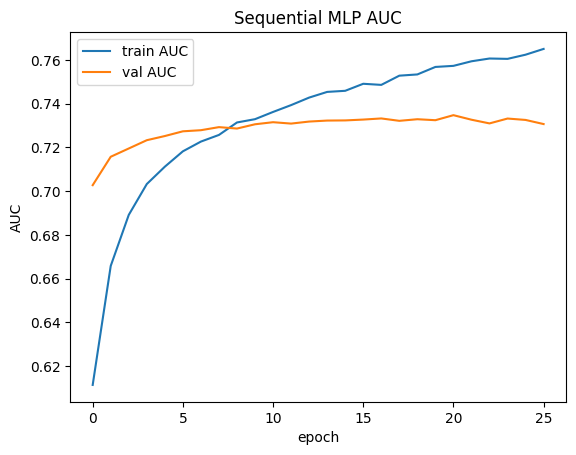

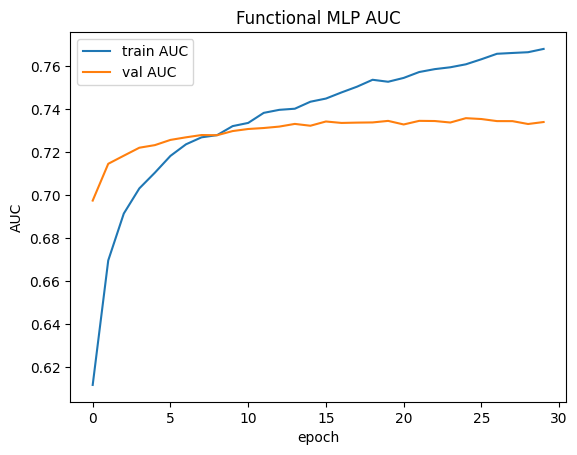

In [20]:

import matplotlib.pyplot as plt

def plot_history(h, title):
    plt.figure()
    plt.plot(h.history['auc'], label='train AUC')
    plt.plot(h.history['val_auc'], label='val AUC')
    plt.title(title); plt.xlabel('epoch'); plt.ylabel('AUC'); plt.legend(); plt.show()

plot_history(hist_seq, "Sequential MLP AUC")
plot_history(hist_func, "Functional MLP AUC")


## 9. Final Evaluation & Confusion Matrices

=== Test Metrics ===
519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sequential MLP (Test) ROC-AUC=0.734 | PR-AUC=0.375 | F1=0.034 | Brier=0.144


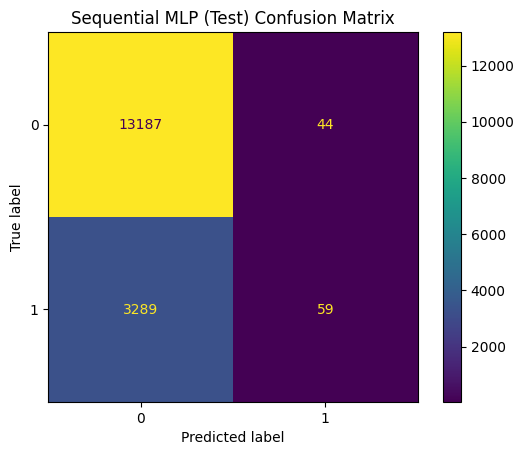

519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Functional MLP (Test) ROC-AUC=0.733 | PR-AUC=0.372 | F1=0.053 | Brier=0.144


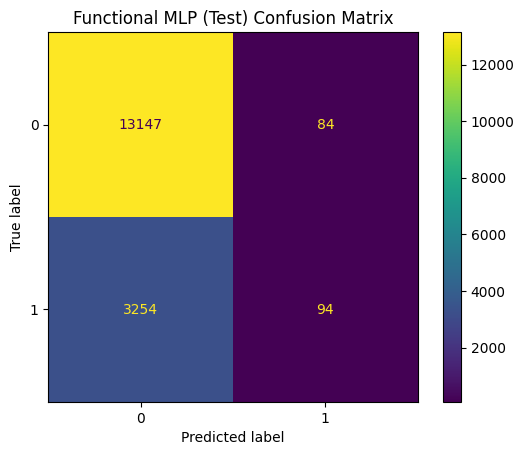

In [21]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, f1_score, brier_score_loss

def eval_binary(model, X, y, name):
    y_prob = model.predict(X).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    roc = roc_auc_score(y, y_prob)
    pr = average_precision_score(y, y_prob)
    f1 = f1_score(y, y_pred)
    brier = brier_score_loss(y, y_prob)
    print(f"{name} ROC-AUC={roc:.3f} | PR-AUC={pr:.3f} | F1={f1:.3f} | Brier={brier:.3f}")
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='d'); plt.title(f"{name} Confusion Matrix"); plt.show()
    return roc, pr, f1, brier

print("=== Test Metrics ===")
_ = eval_binary(seq, X_test_np, y_test, "Sequential MLP (Test)")
_ = eval_binary(func, X_test_np, y_test, "Functional MLP (Test)")


## 10. Log Run to `experiment_log.csv`

In [22]:

import csv, time, datetime, os
with open("experiment_log.csv", "a", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([
        f"run-{int(time.time())}", datetime.date.today().isoformat(), "DL", "MLP-Seq vs MLP-Func",
        "Baseline engineered features",
        "num+onehot", "std+onehot", 0.7, 0.15, 0.15,
        "class_weight", "None", "{'lr':1e-3,'dropout':0.3}", 50, True, 42,
        "ROC-AUC","PR-AUC","","","","", "", "", "", "", "",""
    ])
print("Appended a sample row to experiment_log.csv")


Appended a sample row to experiment_log.csv


# **Experiment 1 -- Logisitic Regression (baseline)**

In [23]:
# --- helpers for evaluation, plotting, and logging (run once) ---
# These use your existing preprocess, X_train/X_val/X_test, y_train/y_val/y_test.
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve
)
import csv, time, datetime

def eval_probs(y_true, y_prob, threshold=0.5, name="model"):
    y_pred = (y_prob >= threshold).astype(int)
    roc = roc_auc_score(y_true, y_prob)
    pr  = average_precision_score(y_true, y_prob)
    f1  = f1_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred)
    print(f"{name}: ROC-AUC={roc:.3f} | PR-AUC={pr:.3f} | F1@{threshold:.2f}={f1:.3f}")
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format='d')
    plt.title(f"{name} — Confusion Matrix"); plt.show()
    return {"roc_auc": roc, "pr_auc": pr, "f1": f1}

def plot_roc_pr(y_true, y_prob, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)

    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC"); plt.show()

    plt.figure(); plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} PR Curve"); plt.show()

def log_run_csv(
    run_id, approach, model, notes, params,
    train_metrics, val_metrics, test_metrics,
    class_weight="none", sampler="none",
    train_split=0.70, val_split=0.15, test_split=0.15, seed=42
):
    row = [
        run_id, datetime.date.today().isoformat(), approach, model, notes,
        "num+onehot", "std+onehot",
        train_split, val_split, test_split,
        class_weight, sampler, str(params), "",
        True, seed,
        "ROC-AUC", "PR-AUC",
        f"{train_metrics['roc_auc']:.4f}/{train_metrics['pr_auc']:.4f}",
        f"{val_metrics['roc_auc']:.4f}/{val_metrics['pr_auc']:.4f}",
        f"{test_metrics['roc_auc']:.4f}/{test_metrics['pr_auc']:.4f}",
        "", f"{test_metrics['roc_auc']:.4f}", f"{test_metrics['pr_auc']:.4f}", "", "", "", ""
    ]
    with open("experiment_log.csv", "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow(row)
    print("Logged to experiment_log.csv:", row[:6])


1a -- Logisitic Regression (no class weighting)

— Plain Logistic Regression —
Train: ROC-AUC=0.665 | PR-AUC=0.305 | F1@0.50=0.029


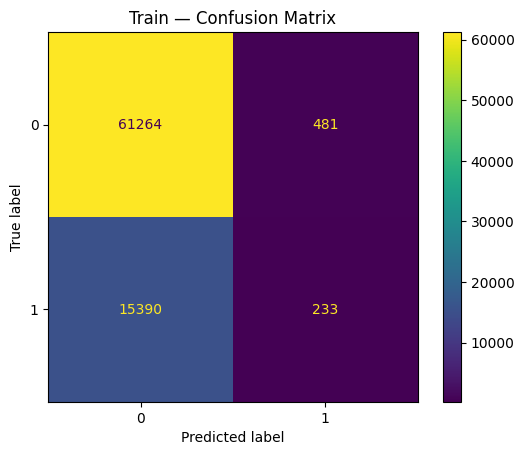

Val: ROC-AUC=0.664 | PR-AUC=0.305 | F1@0.50=0.029


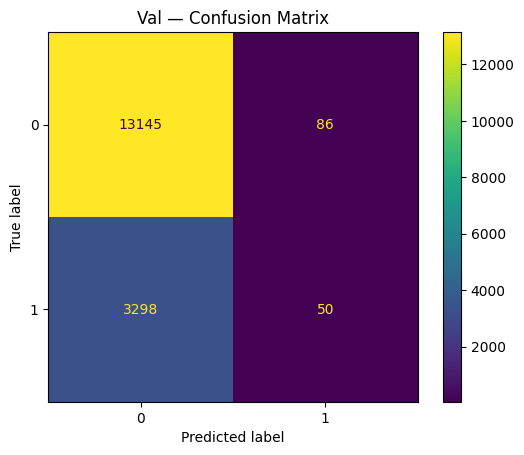

Test: ROC-AUC=0.666 | PR-AUC=0.308 | F1@0.50=0.026


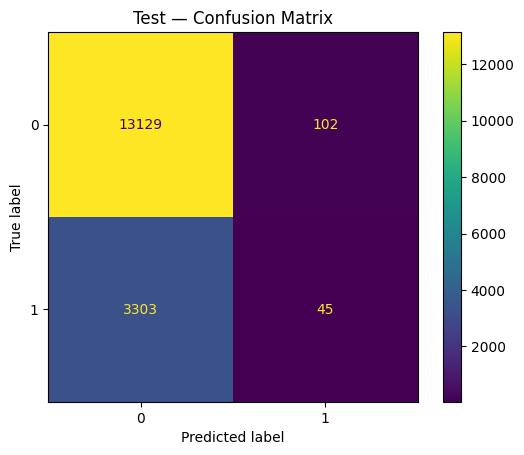

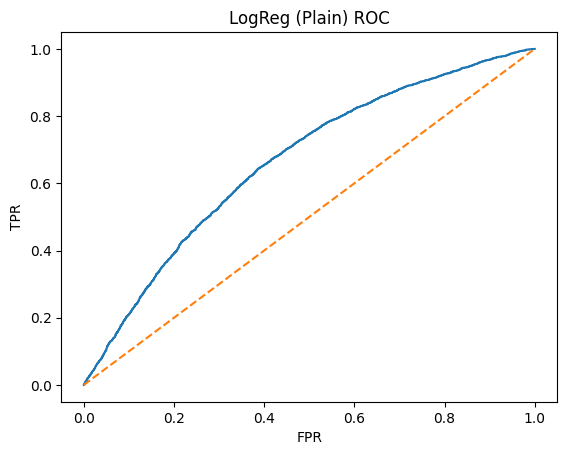

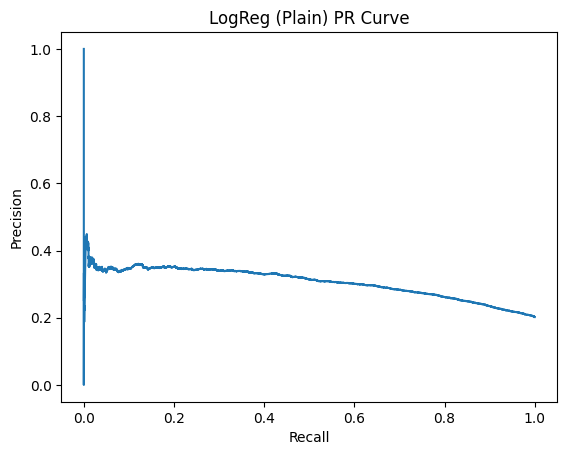

Logged to experiment_log.csv: ['exp1a-1760870422', '2025-10-19', 'ML', 'LogisticRegression', 'Baseline, no class_weight', 'num+onehot']


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logreg_plain = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500, n_jobs=None))
])
logreg_plain.fit(X_train, y_train)

# probabilities for splits
ytr_p = logreg_plain.predict_proba(X_train)[:,1]
yva_p = logreg_plain.predict_proba(X_val)[:,1]
yte_p = logreg_plain.predict_proba(X_test)[:,1]

print("— Plain Logistic Regression —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "LogReg (Plain)")

# Log run
log_run_csv(
    run_id=f"exp1a-{int(time.time())}",
    approach="ML",
    model="LogisticRegression",
    notes="Baseline, no class_weight",
    params={"max_iter": 500},
    train_metrics=m_tr, val_metrics=m_va, test_metrics=m_te,
    class_weight="none"
)


— Logistic Regression (balanced) —
Train: ROC-AUC=0.671 | PR-AUC=0.305 | F1@0.50=0.407


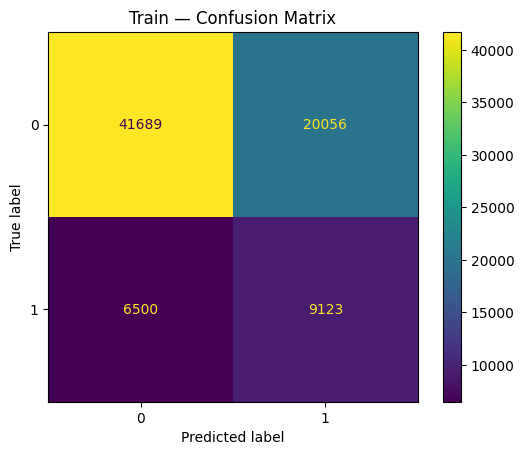

Val: ROC-AUC=0.669 | PR-AUC=0.305 | F1@0.50=0.404


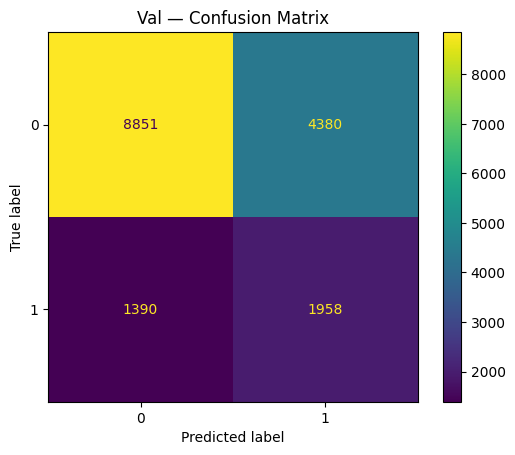

Test: ROC-AUC=0.672 | PR-AUC=0.309 | F1@0.50=0.411


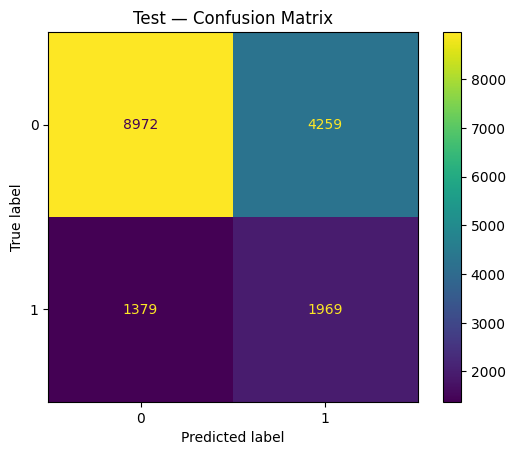

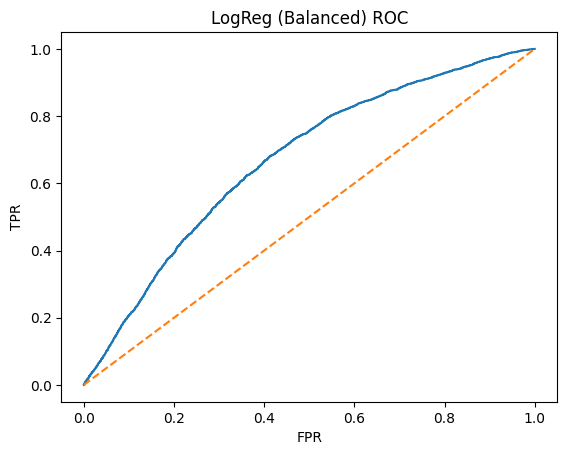

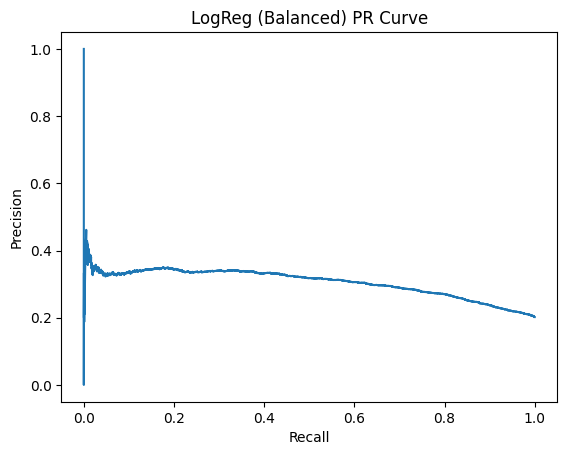

Logged to experiment_log.csv: ['exp1b-1760870425', '2025-10-19', 'ML', 'LogisticRegression', 'class_weight=balanced', 'num+onehot']


In [25]:
# 1b — Logistic Regression (class_weight='balanced')

logreg_bal = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=None))
])
logreg_bal.fit(X_train, y_train)

ytr_p = logreg_bal.predict_proba(X_train)[:,1]
yva_p = logreg_bal.predict_proba(X_val)[:,1]
yte_p = logreg_bal.predict_proba(X_test)[:,1]

print("— Logistic Regression (balanced) —")
m_tr_b = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va_b = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te_b = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "LogReg (Balanced)")

log_run_csv(
    run_id=f"exp1b-{int(time.time())}",
    approach="ML",
    model="LogisticRegression",
    notes="class_weight=balanced",
    params={"max_iter": 500, "class_weight": "balanced"},
    train_metrics=m_tr_b, val_metrics=m_va_b, test_metrics=m_te_b,
    class_weight="balanced"
)


# **Experiment 2: Random Forest Classsifer**

— Random Forest (Baseline, 200 trees) —
Train: ROC-AUC=0.999 | PR-AUC=0.996 | F1@0.50=0.967


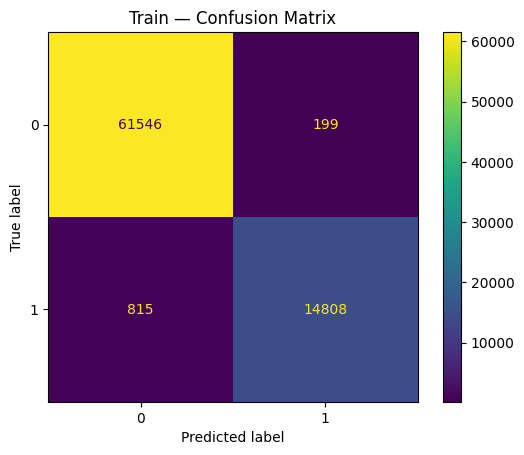

Val: ROC-AUC=0.722 | PR-AUC=0.368 | F1@0.50=0.252


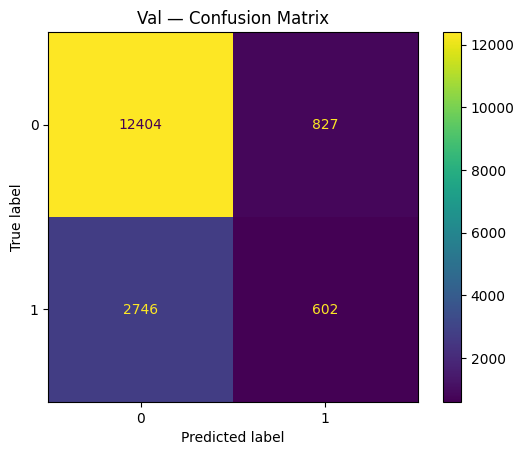

Test: ROC-AUC=0.726 | PR-AUC=0.366 | F1@0.50=0.258


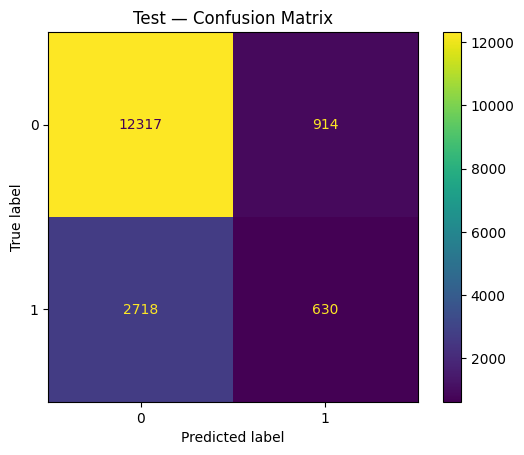

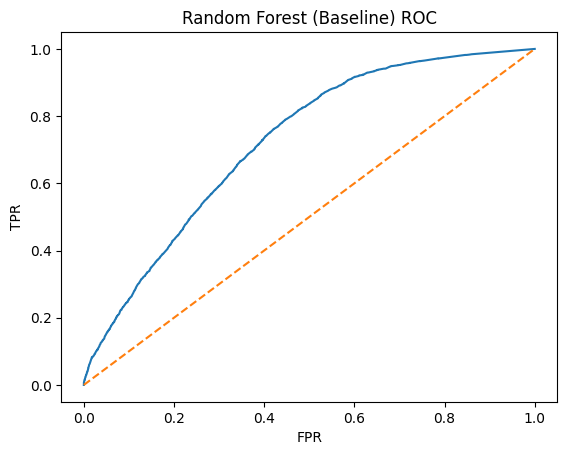

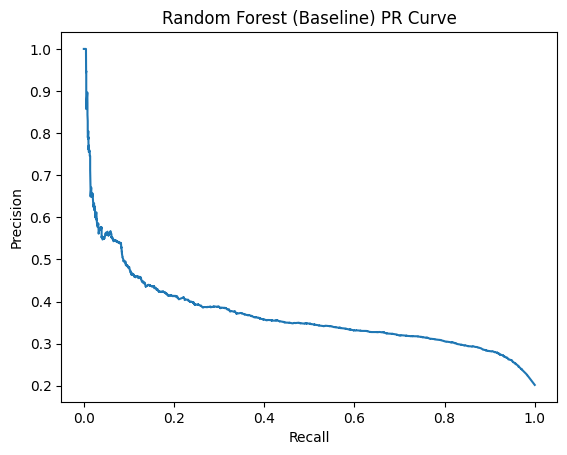

Logged to experiment_log.csv: ['exp2a-1760870887', '2025-10-19', 'ML', 'RandomForest', 'Baseline 200 trees, default depth', 'num+onehot']


In [26]:
# Baseline Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Baseline Random Forest
rf_base = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,  # number of trees
        random_state=42,
        n_jobs=-1
    ))
])

rf_base.fit(X_train, y_train)

# Predict probabilities
ytr_p = rf_base.predict_proba(X_train)[:,1]
yva_p = rf_base.predict_proba(X_val)[:,1]
yte_p = rf_base.predict_proba(X_test)[:,1]

print("— Random Forest (Baseline, 200 trees) —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "Random Forest (Baseline)")

log_run_csv(
    run_id=f"exp2a-{int(time.time())}",
    approach="ML",
    model="RandomForest",
    notes="Baseline 200 trees, default depth",
    params={"n_estimators":200},
    train_metrics=m_tr, val_metrics=m_va, test_metrics=m_te
)


— Random Forest (max_depth=10, balanced) —
Train: ROC-AUC=0.753 | PR-AUC=0.399 | F1@0.50=0.452


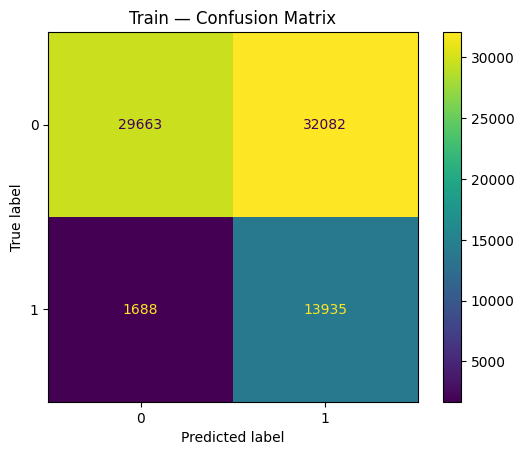

Val: ROC-AUC=0.727 | PR-AUC=0.357 | F1@0.50=0.440


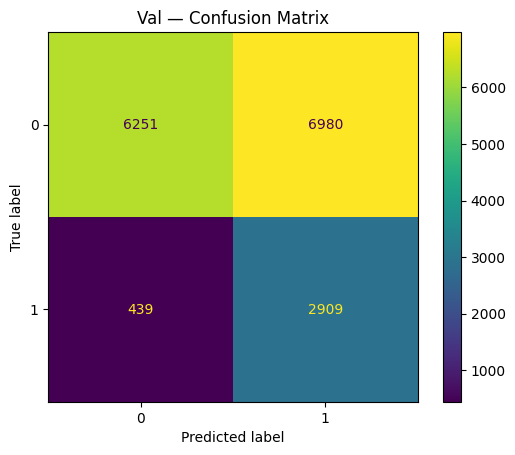

Test: ROC-AUC=0.727 | PR-AUC=0.350 | F1@0.50=0.442


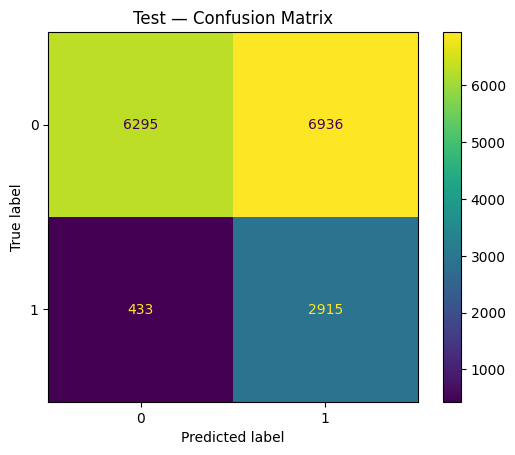

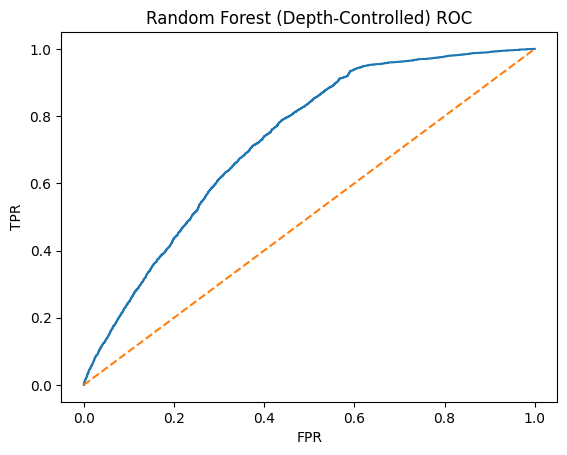

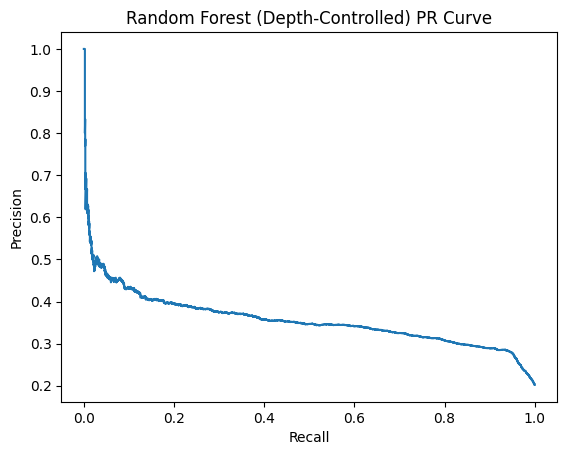

Logged to experiment_log.csv: ['exp2b-1760870917', '2025-10-19', 'ML', 'RandomForest', 'Depth=10, balanced, min_samples_split=20', 'num+onehot']


In [27]:


rf_depth = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=10,          # limit depth to control complexity
        min_samples_split=20,
        class_weight="balanced",  # handle imbalance
        random_state=42,
        n_jobs=-1
    ))
])

rf_depth.fit(X_train, y_train)

ytr_p = rf_depth.predict_proba(X_train)[:,1]
yva_p = rf_depth.predict_proba(X_val)[:,1]
yte_p = rf_depth.predict_proba(X_test)[:,1]

print("— Random Forest (max_depth=10, balanced) —")
m_tr_d = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va_d = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te_d = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "Random Forest (Depth-Controlled)")

log_run_csv(
    run_id=f"exp2b-{int(time.time())}",
    approach="ML",
    model="RandomForest",
    notes="Depth=10, balanced, min_samples_split=20",
    params={"n_estimators":300, "max_depth":10, "class_weight":"balanced"},
    train_metrics=m_tr_d, val_metrics=m_va_d, test_metrics=m_te_d,
    class_weight="balanced"
)


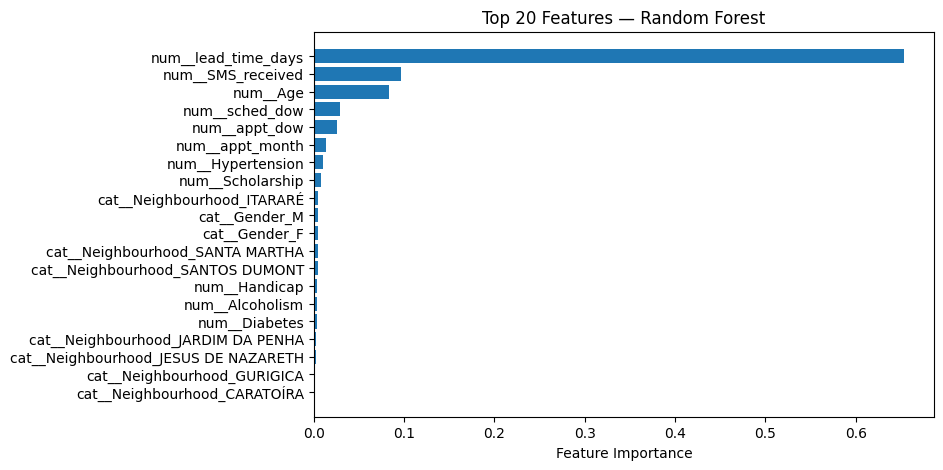

In [28]:
# Extract importance from trained RF
rf_model = rf_depth.named_steps["clf"]
feat_names = preprocess.get_feature_names_out()

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # top 20

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [feat_names[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features — Random Forest")
plt.show()


# ***Experiment 3 : XGBoost***

— XGBoost (Baseline) —
Train: ROC-AUC=0.802 | PR-AUC=0.510 | F1@0.50=0.148


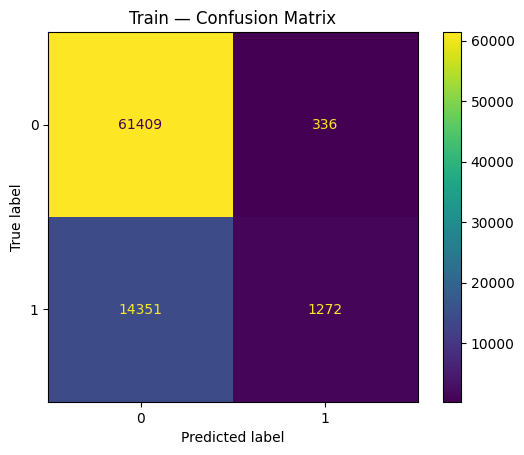

Val: ROC-AUC=0.743 | PR-AUC=0.390 | F1@0.50=0.093


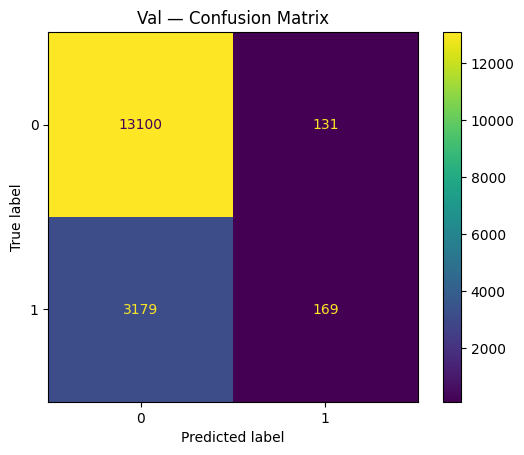

Test: ROC-AUC=0.743 | PR-AUC=0.390 | F1@0.50=0.099


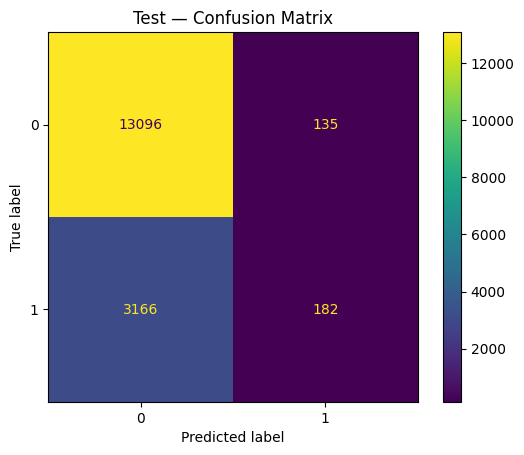

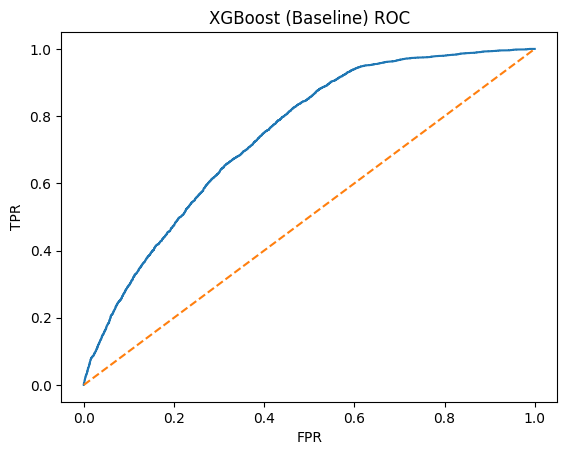

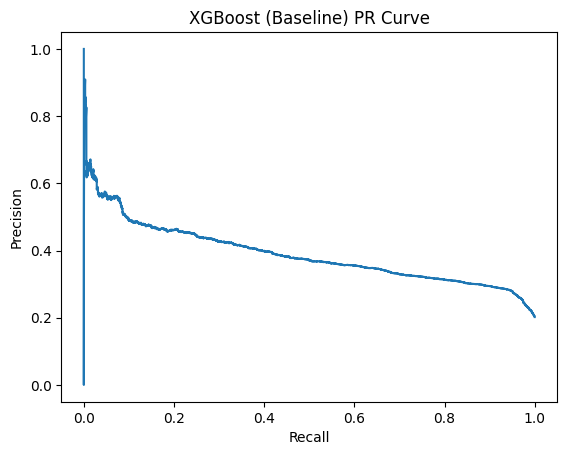

Logged to experiment_log.csv: ['exp3a-1760870921', '2025-10-19', 'ML', 'XGBoost', 'Baseline 200 estimators, lr=0.1, depth=6', 'num+onehot']


In [29]:
# Baseline XGBoost

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Baseline XGBoost (default parameters)
xgb_base = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_base.fit(X_train, y_train)

# Evaluate
ytr_p = xgb_base.predict_proba(X_train)[:,1]
yva_p = xgb_base.predict_proba(X_val)[:,1]
yte_p = xgb_base.predict_proba(X_test)[:,1]

print("— XGBoost (Baseline) —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "XGBoost (Baseline)")

log_run_csv(
    run_id=f"exp3a-{int(time.time())}",
    approach="ML",
    model="XGBoost",
    notes="Baseline 200 estimators, lr=0.1, depth=6",
    params={"n_estimators":200, "learning_rate":0.1, "max_depth":6},
    train_metrics=m_tr, val_metrics=m_va, test_metrics=m_te
)


— XGBoost (Tuned) —
Train: ROC-AUC=0.767 | PR-AUC=0.424 | F1@0.50=0.476


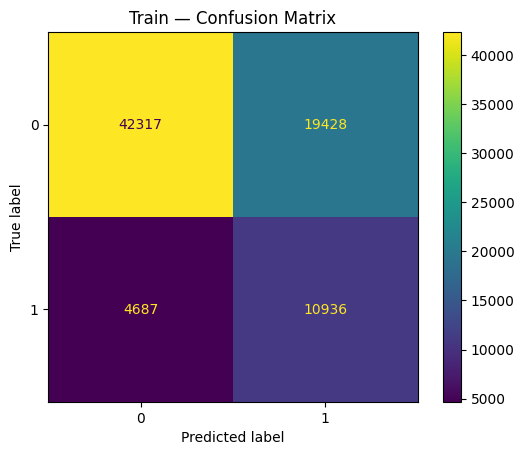

Val: ROC-AUC=0.739 | PR-AUC=0.375 | F1@0.50=0.449


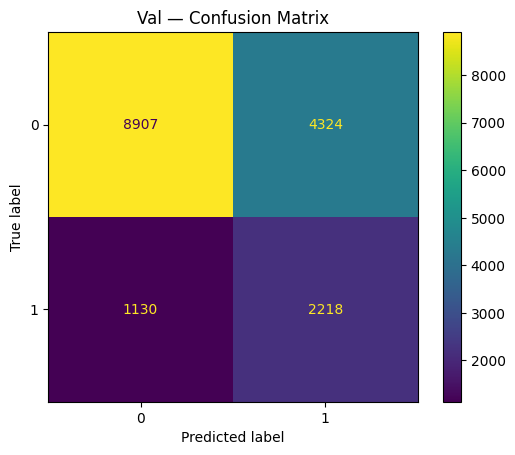

Test: ROC-AUC=0.739 | PR-AUC=0.378 | F1@0.50=0.445


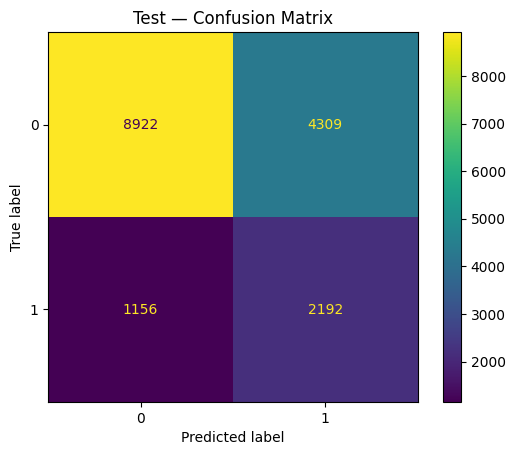

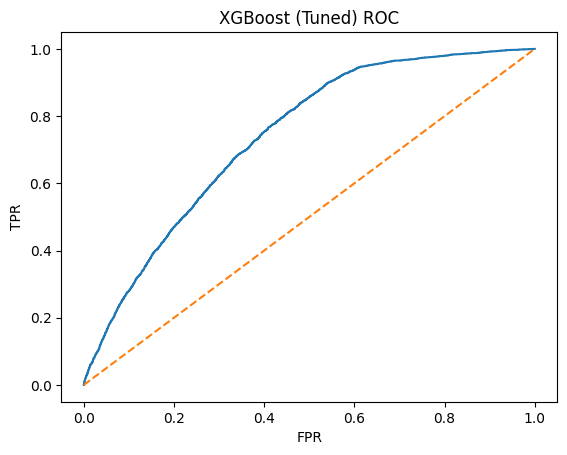

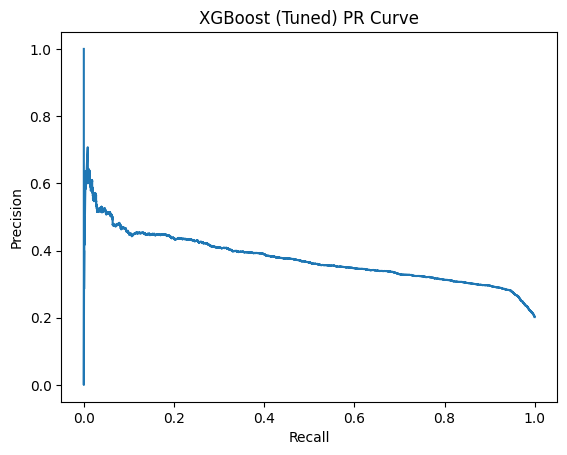

Logged to experiment_log.csv: ['exp3b-1760870927', '2025-10-19', 'ML', 'XGBoost', 'Regularized: lr=0.03, depth=5, L1=0.1, L2=1.0, scale_pos_weight=3', 'num+onehot']


In [30]:
# Tuned XGBoost(regurized)

xgb_tuned = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=400,
        learning_rate=0.03,   # slower learning
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,       # L2 regularization
        reg_alpha=0.1,        # L1 regularization
        scale_pos_weight=3,   # handle class imbalance
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_tuned.fit(X_train, y_train)

ytr_p = xgb_tuned.predict_proba(X_train)[:,1]
yva_p = xgb_tuned.predict_proba(X_val)[:,1]
yte_p = xgb_tuned.predict_proba(X_test)[:,1]

print("— XGBoost (Tuned) —")
m_tr_t = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va_t = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te_t = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "XGBoost (Tuned)")

log_run_csv(
    run_id=f"exp3b-{int(time.time())}",
    approach="ML",
    model="XGBoost",
    notes="Regularized: lr=0.03, depth=5, L1=0.1, L2=1.0, scale_pos_weight=3",
    params={"n_estimators":400, "learning_rate":0.03, "max_depth":5,
            "reg_lambda":1.0, "reg_alpha":0.1, "scale_pos_weight":3},
    train_metrics=m_tr_t, val_metrics=m_va_t, test_metrics=m_te_t,
    class_weight="scale_pos_weight=3"
)


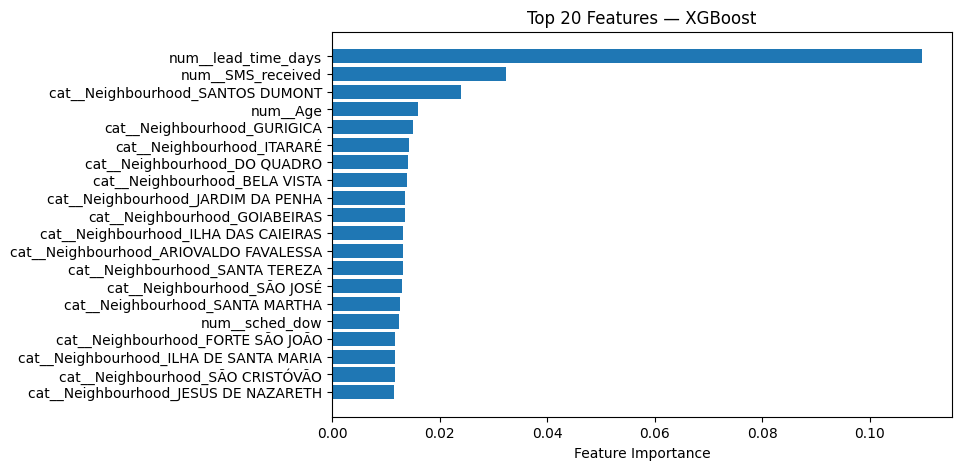

In [31]:
xgb_model = xgb_tuned.named_steps["clf"]
feat_names = preprocess.get_feature_names_out()

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [feat_names[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features — XGBoost")
plt.show()


# **Experiement 4 - Sequential MLP**: Using TensorFlow/Keras Sequentail API

Build, train, and evaluate a Multi-Layer Perceptron (MLP) that predicts clinic no-shows using the engineered tabular features you've prepared.

In [32]:
# Step 1 - Prepare Data
# We’ll reuse the same preprocessing transformer but convert the result to NumPy arrays for TensorFlow.
# Convert preprocessed data to numpy arrays
X_train_np = preprocess.fit_transform(X_train)
X_val_np = preprocess.transform(X_val)
X_test_np = preprocess.transform(X_test)

input_dim = X_train_np.shape[1]
print("Input dimension:", input_dim)


Input dimension: 95


In [33]:
#Step 2 - Build a Sequential Model (Baseline)

from tensorflow import keras
from tensorflow.keras import layers

def build_seq_mlp(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), keras.metrics.AUC(curve='PR', name='pr_auc')]
    )
    return model

seq_model = build_seq_mlp(input_dim)
seq_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,137 (231.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [34]:
#Step 3 - Train the model

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, monitor='val_auc', mode='max', restore_best_weights=True)
]

history_seq = seq_model.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=50,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - auc: 0.5900 - loss: 0.6975 - pr_auc: 0.2524 - val_auc: 0.6982 - val_loss: 0.4806 - val_pr_auc: 0.3297
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc: 0.6570 - loss: 0.5023 - pr_auc: 0.2979 - val_auc: 0.7099 - val_loss: 0.4647 - val_pr_auc: 0.3392
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc: 0.6843 - loss: 0.4798 - pr_auc: 0.3172 - val_auc: 0.7208 - val_loss: 0.4544 - val_pr_auc: 0.3484
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - auc: 0.7001 - loss: 0.4686 - pr_auc: 0.3345 - val_auc: 0.7230 - val_loss: 0.4509 - val_pr_auc: 0.3487
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - auc: 0.7107 - loss: 0.4605 - pr_auc: 0.3425 - val_auc: 0.7245 - val_loss: 0.4496 - val_pr_auc: 0.3521
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc: 0.7152 - loss: 0.4568 - pr_auc: 0.3482 - val_auc: 0.7263 - val_loss: 0.4478 - val_pr_auc: 0.3541
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc

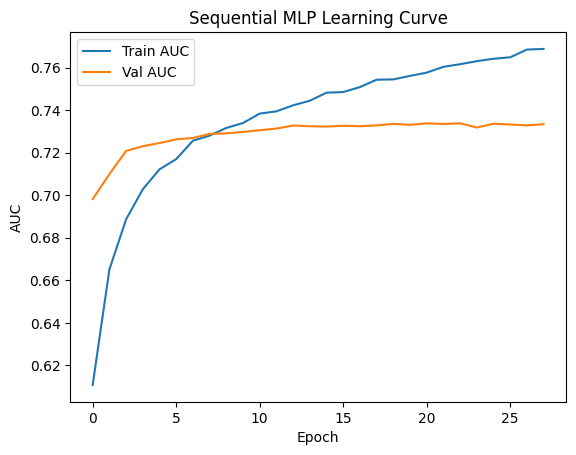

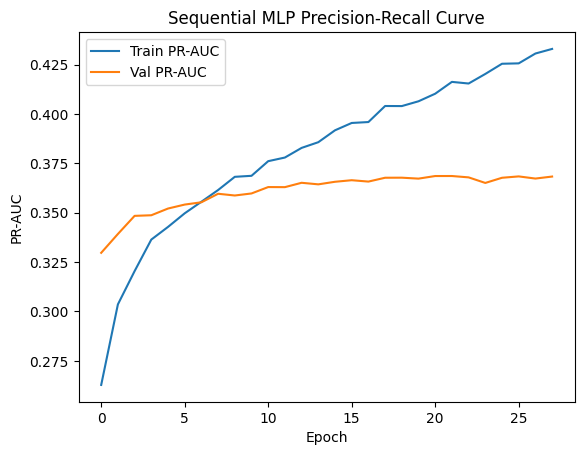

In [35]:
# Step 4 - Plot Learning Curves

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_seq.history['auc'], label='Train AUC')
plt.plot(history_seq.history['val_auc'], label='Val AUC')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('Sequential MLP Learning Curve'); plt.legend(); plt.show()

plt.figure()
plt.plot(history_seq.history['pr_auc'], label='Train PR-AUC')
plt.plot(history_seq.history['val_pr_auc'], label='Val PR-AUC')
plt.xlabel('Epoch'); plt.ylabel('PR-AUC'); plt.title('Sequential MLP Precision-Recall Curve'); plt.legend(); plt.show()


2418/2418 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
— Sequential MLP Results —
Train: ROC-AUC=0.782 | PR-AUC=0.458 | F1@0.50=0.069


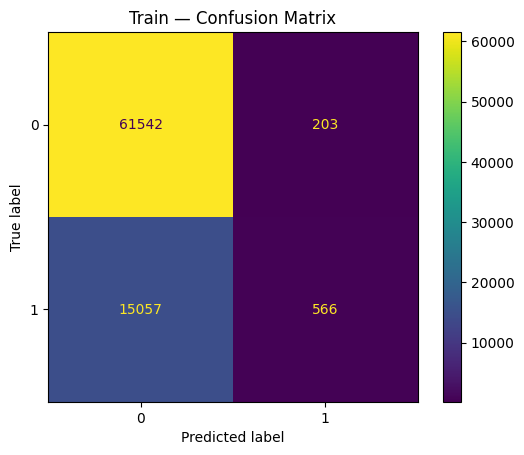

Val: ROC-AUC=0.734 | PR-AUC=0.368 | F1@0.50=0.043


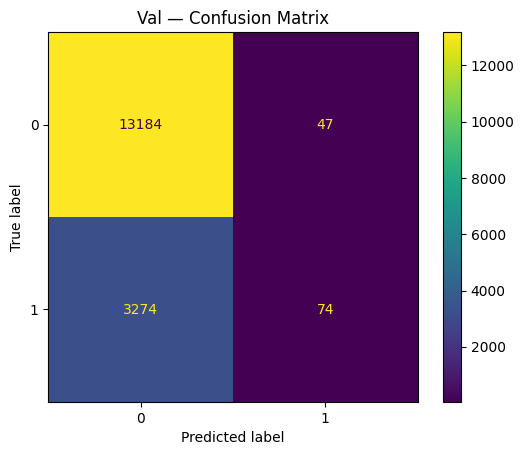

Test: ROC-AUC=0.732 | PR-AUC=0.368 | F1@0.50=0.044


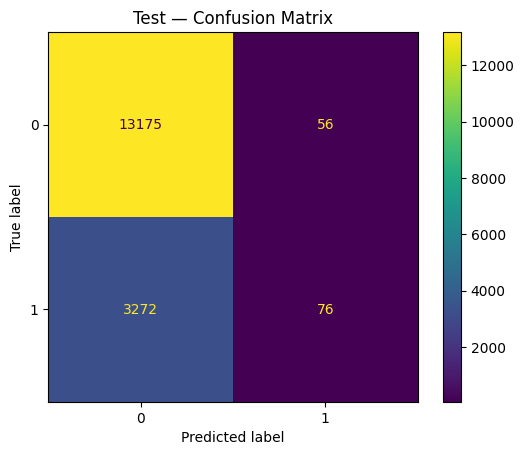

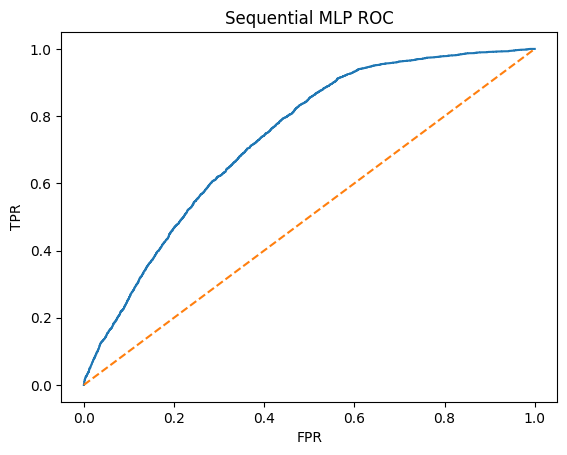

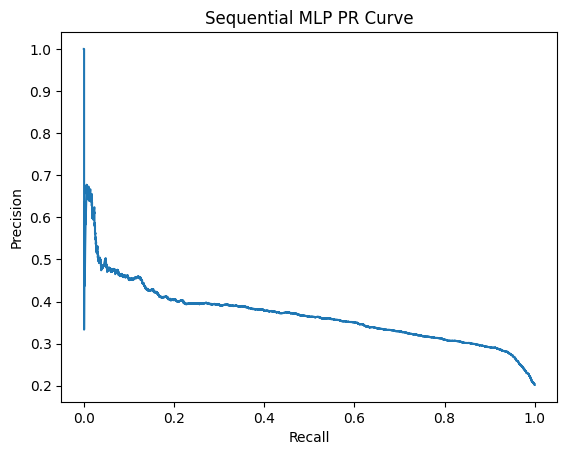

In [36]:
#Step 5 - Evaluate on Validation & Test

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

ytr_p = seq_model.predict(X_train_np).ravel()
yva_p = seq_model.predict(X_val_np).ravel()
yte_p = seq_model.predict(X_test_np).ravel()

print("— Sequential MLP Results —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")

plot_roc_pr(y_val, yva_p, "Sequential MLP")


In [37]:
#Step 6 - Log Results
log_run_csv(
    run_id=f"exp4a-{int(time.time())}",
    approach="DL",
    model="Sequential MLP",
    notes="Baseline 2 hidden layers (256,128), dropout=0.3, Adam(1e-3)",
    params={"layers":[256,128],"dropout":0.3,"optimizer":"Adam(1e-3)"},
    train_metrics=m_tr, val_metrics=m_va, test_metrics=m_te
)


Logged to experiment_log.csv: ['exp4a-1760871023', '2025-10-19', 'DL', 'Sequential MLP', 'Baseline 2 hidden layers (256,128), dropout=0.3, Adam(1e-3)', 'num+onehot']


# **Experiment 5 - Functional MLP (skip/concat)**

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - auc: 0.5840 - loss: 0.6659 - pr_auc: 0.2527 - val_auc: 0.7062 - val_loss: 0.4819 - val_pr_auc: 0.3388
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - auc: 0.6570 - loss: 0.4976 - pr_auc: 0.3053 - val_auc: 0.7147 - val_loss: 0.4646 - val_pr_auc: 0.3418
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.6837 - loss: 0.4781 - pr_auc: 0.3182 - val_auc: 0.7194 - val_loss: 0.4549 - val_pr_auc: 0.3479
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.6994 - loss: 0.4679 - pr_auc: 0.3305 - val_auc: 0.7211 - val_loss: 0.4520 - val_pr_auc: 0.3494
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7081 - loss: 0.4614 - pr_auc: 0.3387 - val_auc: 0.7244 - val_loss: 0.4493 - val_pr_auc: 0.3530
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - auc: 0.7150 - loss: 0.4570 - pr_auc: 0.3444 - val_auc: 0.7244 - val_loss: 0.4483 - val_pr_auc: 0.3544
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - auc

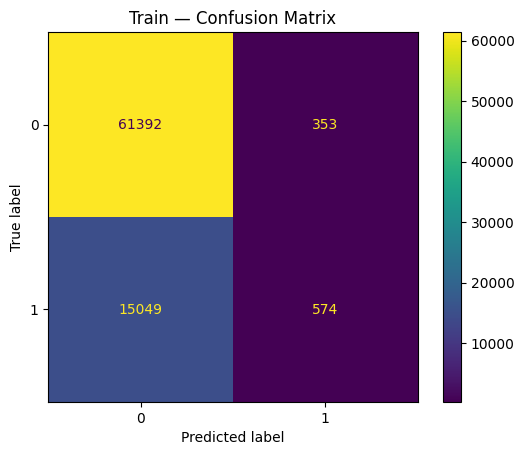

Val: ROC-AUC=0.733 | PR-AUC=0.365 | F1@0.50=0.049


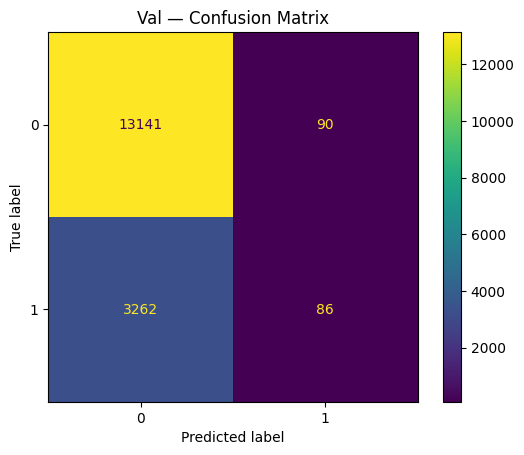

Test: ROC-AUC=0.733 | PR-AUC=0.371 | F1@0.50=0.061


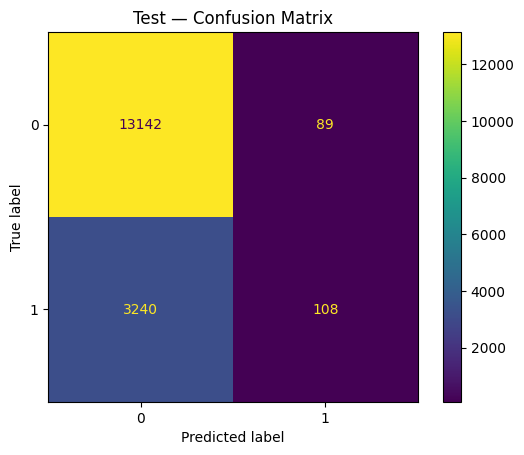

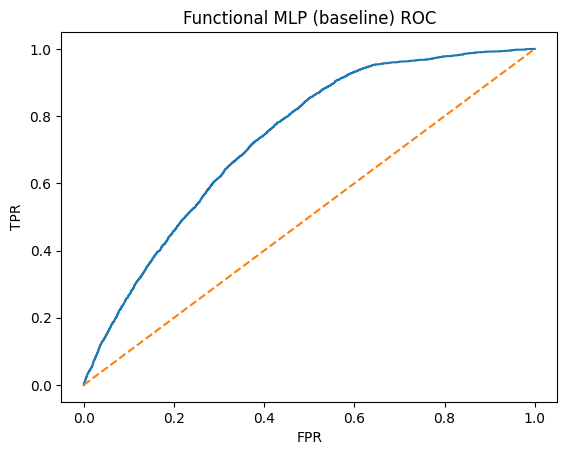

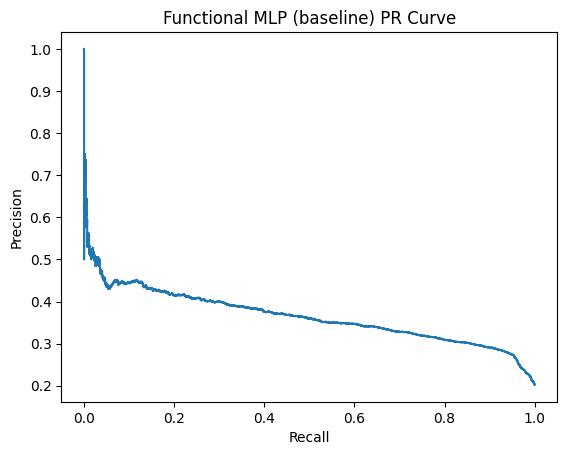

Logged to experiment_log.csv: ['exp5a-1760871130', '2025-10-19', 'DL', 'Functional MLP (skip/concat)', '256→128 with skip/concat, dropout=0.3, Adam(1e-3)', 'num+onehot']


In [38]:
#5a) Functional MLP (baseline)

# Ensure preprocessed arrays exist (safe to re-run)
X_train_np = preprocess.fit_transform(X_train)
X_val_np   = preprocess.transform(X_val)
X_test_np  = preprocess.transform(X_test)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X_train_np.shape[1]

def build_functional_mlp(input_dim):
    inp = keras.Input(shape=(input_dim,))
    x   = layers.Dense(256, activation='relu')(inp)
    x   = layers.BatchNormalization()(x)
    x   = layers.Dropout(0.3)(x)
    skip = x
    x   = layers.Dense(128, activation='relu')(x)
    x   = layers.Concatenate()([x, skip])   # skip/concat trick
    x   = layers.BatchNormalization()(x)
    x   = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'),
                 keras.metrics.AUC(curve='PR', name='pr_auc')]
    )
    return model

func = build_functional_mlp(input_dim)
callbacks = [keras.callbacks.EarlyStopping(patience=5, monitor='val_auc', mode='max', restore_best_weights=True)]
hist_func = func.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=50, batch_size=512, callbacks=callbacks, verbose=1
)

# Evaluate
ytr_p = func.predict(X_train_np).ravel()
yva_p = func.predict(X_val_np).ravel()
yte_p = func.predict(X_test_np).ravel()

print("— Functional MLP (baseline) —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "Functional MLP (baseline)")

log_run_csv(
    run_id=f"exp5a-{int(time.time())}",
    approach="DL",
    model="Functional MLP (skip/concat)",
    notes="256→128 with skip/concat, dropout=0.3, Adam(1e-3)",
    params={"layers":[256,128],"skip":"concat","dropout":0.3,"optimizer":"Adam(1e-3)"},
    train_metrics=m_tr, val_metrics=m_va, test_metrics=m_te
)


In [39]:
#5b Functional MLP + Class Weights(imbalance-aware)
# Compute class weights from training labels
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0,1])
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {0: float(cw[0]), 1: float(cw[1])}
class_weight_dict


{0: 0.6265122681998543, 1: 2.4760929398963065}

Epoch 1/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - auc: 0.6228 - loss: 0.7473 - pr_auc: 0.2767 - val_auc: 0.7066 - val_loss: 0.6103 - val_pr_auc: 0.3364
Epoch 2/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.6832 - loss: 0.6536 - pr_auc: 0.3140 - val_auc: 0.7170 - val_loss: 0.6135 - val_pr_auc: 0.3433
Epoch 3/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7021 - loss: 0.6287 - pr_auc: 0.3311 - val_auc: 0.7205 - val_loss: 0.6118 - val_pr_auc: 0.3463
Epoch 4/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - auc: 0.7106 - loss: 0.6190 - pr_auc: 0.3387 - val_auc: 0.7227 - val_loss: 0.6220 - val_pr_auc: 0.3495
Epoch 5/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7176 - loss: 0.6096 - pr_auc: 0.3432 - val_auc: 0.7246 - val_loss: 0.6131 - val_pr_auc: 0.3510
Epoch 6/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - auc: 0.7200 - loss: 0.6070 - pr_auc: 0.3459 - val_auc: 0.7262 - val_loss: 0.6113 - val_pr_auc: 0.3548
Epoch 7/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc

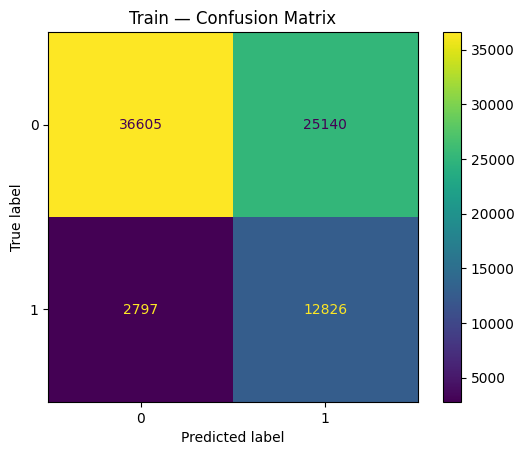

Val: ROC-AUC=0.735 | PR-AUC=0.369 | F1@0.50=0.447


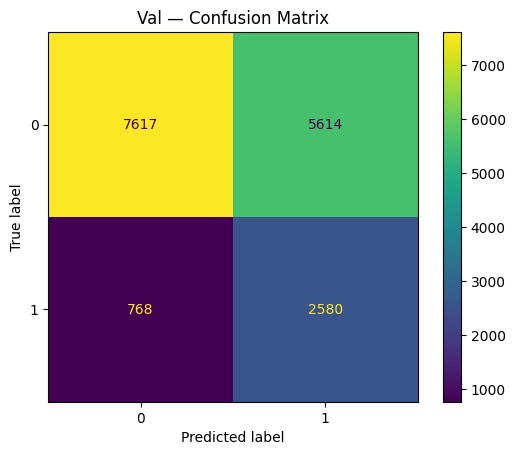

Test: ROC-AUC=0.732 | PR-AUC=0.370 | F1@0.50=0.448


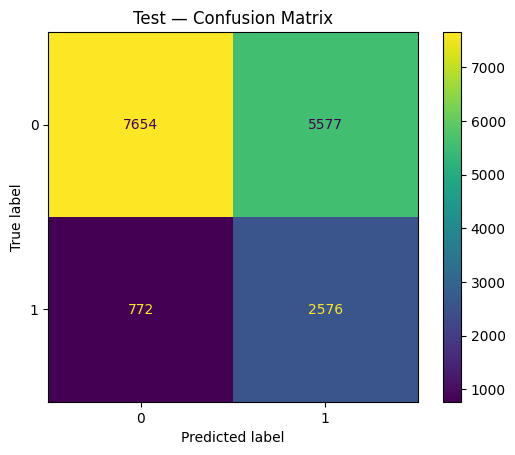

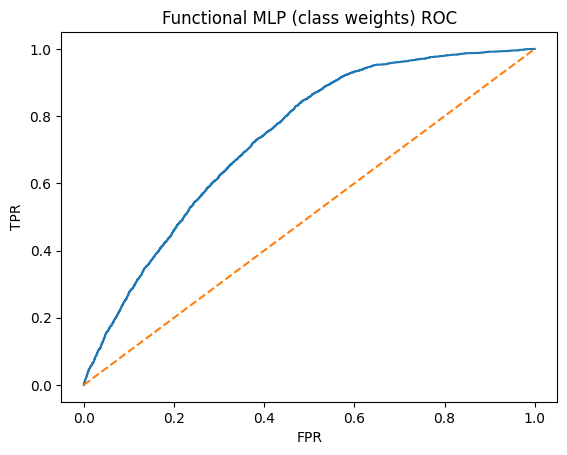

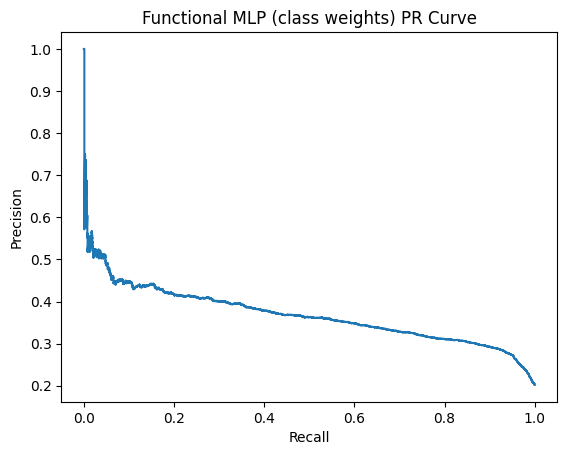

Logged to experiment_log.csv: ['exp5b-1760871252', '2025-10-19', 'DL', 'Functional MLP (skip/concat + class weights)', 'class_weight=balanced via sklearn; 256→128; dropout=0.3', 'num+onehot']


In [40]:
func_cw = build_functional_mlp(input_dim)
hist_func_cw = func_cw.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=60, batch_size=512, callbacks=callbacks, verbose=1,
    class_weight=class_weight_dict
)

# Evaluate
ytr_p = func_cw.predict(X_train_np).ravel()
yva_p = func_cw.predict(X_val_np).ravel()
yte_p = func_cw.predict(X_test_np).ravel()

print("— Functional MLP (class weights) —")
m_tr_cw = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va_cw = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te_cw = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "Functional MLP (class weights)")

log_run_csv(
    run_id=f"exp5b-{int(time.time())}",
    approach="DL",
    model="Functional MLP (skip/concat + class weights)",
    notes="class_weight=balanced via sklearn; 256→128; dropout=0.3",
    params={"layers":[256,128],"skip":"concat","dropout":0.3,"class_weight":class_weight_dict},
    train_metrics=m_tr_cw, val_metrics=m_va_cw, test_metrics=m_te_cw,
    class_weight="balanced"
)


# **Experiment 6: Imbalance Strategies**

Goal: improve detection of the minority class (no-shows) and strengthen your PR-AUC / recall without wrecking precision.

We’ll try three approaches:

Class weights (ML & DL) – you already tested this for DL in Exp 5b; we’ll mirror for ML.

SMOTE (oversampling) – fit only on training to avoid leakage.

Focal loss (DL) – optional but powerful for imbalanced data.

— RF (class_weight=balanced) —
Train: ROC-AUC=0.754 | PR-AUC=0.401 | F1@0.50=0.451


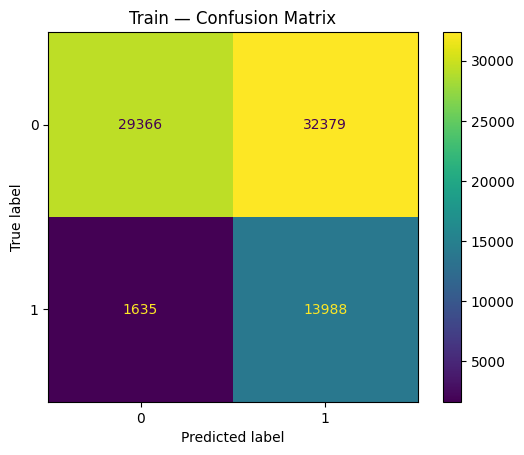

Val: ROC-AUC=0.727 | PR-AUC=0.357 | F1@0.50=0.439


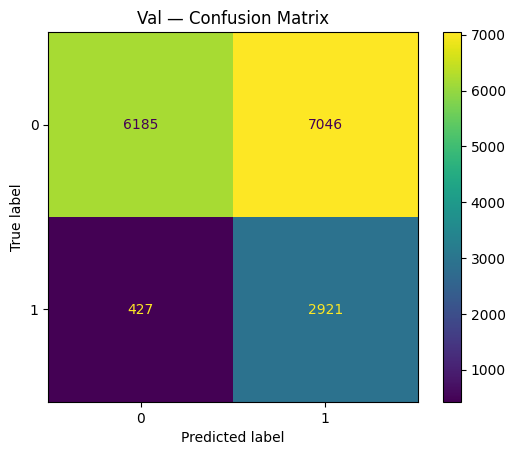

Test: ROC-AUC=0.727 | PR-AUC=0.351 | F1@0.50=0.442


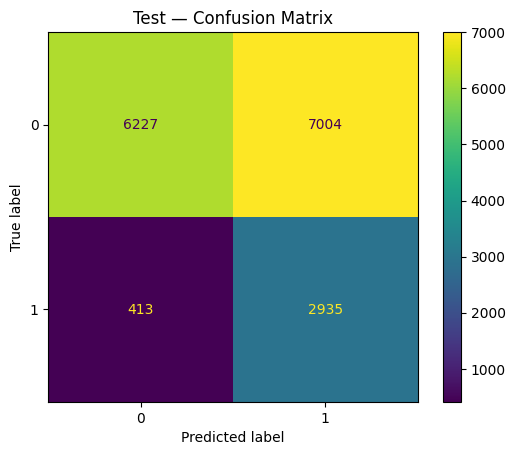

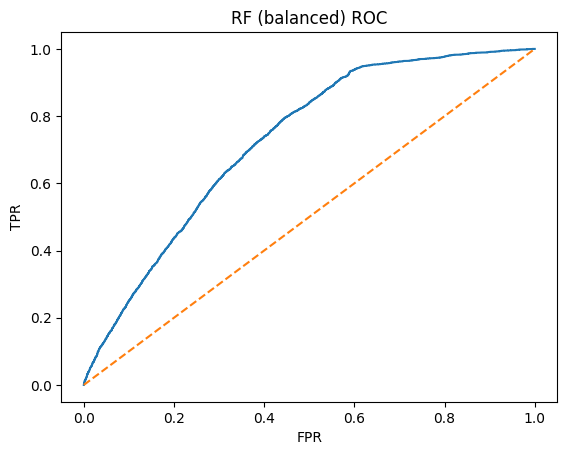

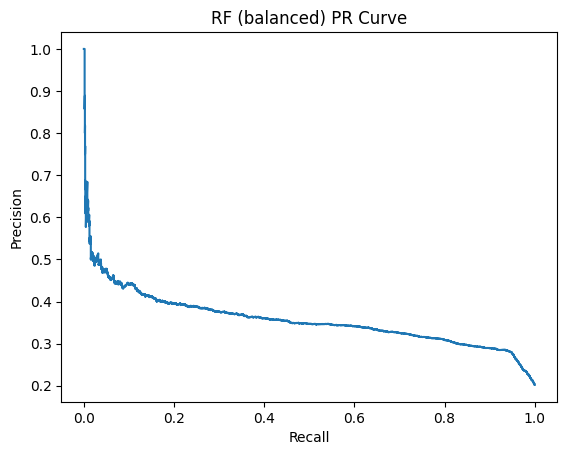

Logged to experiment_log.csv: ['exp6a-1760871291', '2025-10-19', 'ML', 'RandomForest', 'class_weight=balanced', 'num+onehot']


In [41]:
#6.1) Class Weights for ML ( RF / XGB)

# Random Forest with class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_w = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=10, min_samples_split=20,
        class_weight="balanced", random_state=42, n_jobs=-1
    ))
]).fit(X_train, y_train)

ytr_p = rf_w.predict_proba(X_train)[:,1]
yva_p = rf_w.predict_proba(X_val)[:,1]
yte_p = rf_w.predict_proba(X_test)[:,1]
print("— RF (class_weight=balanced) —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "RF (balanced)")
log_run_csv(f"exp6a-{int(time.time())}","ML","RandomForest",
            "class_weight=balanced",
            {"n_estimators":400,"max_depth":10,"min_samples_split":20,"class_weight":"balanced"},
            m_tr,m_va,m_te,class_weight="balanced")


— XGB (scale_pos_weight=3) —
Train: ROC-AUC=0.781 | PR-AUC=0.452 | F1@0.50=0.489


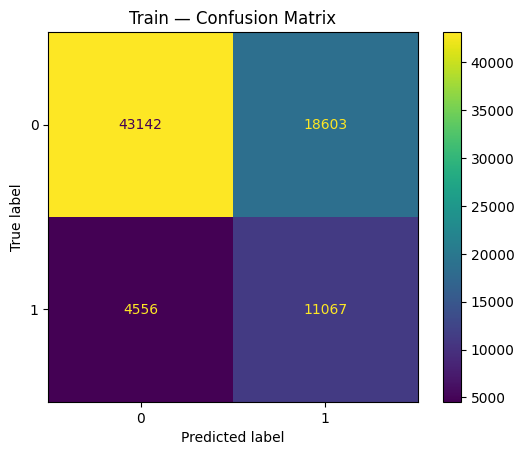

Val: ROC-AUC=0.742 | PR-AUC=0.379 | F1@0.50=0.449


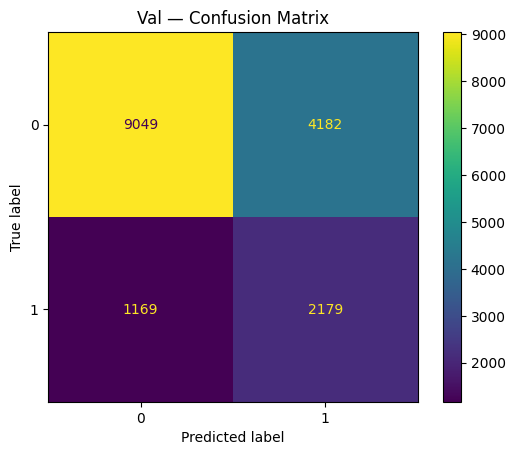

Test: ROC-AUC=0.740 | PR-AUC=0.380 | F1@0.50=0.447


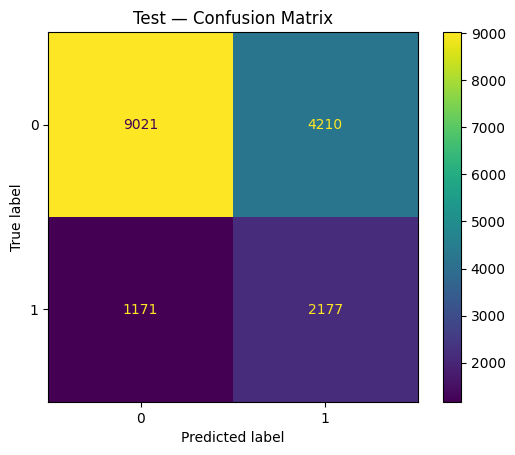

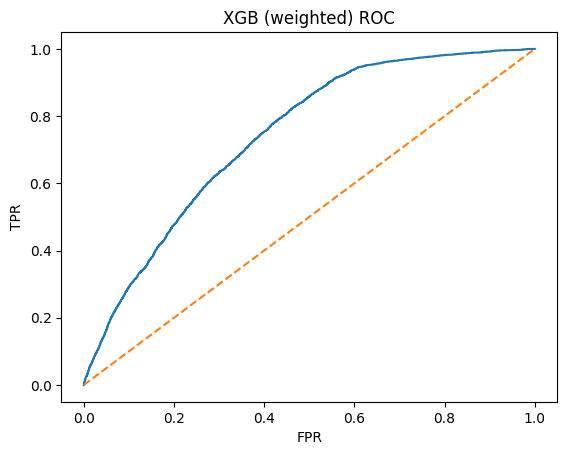

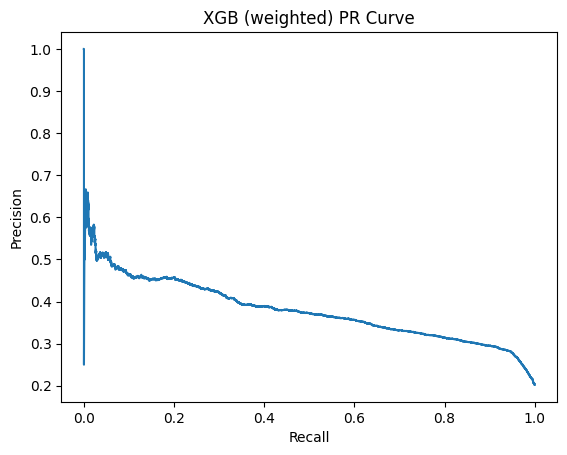

Logged to experiment_log.csv: ['exp6b-1760871298', '2025-10-19', 'ML', 'XGBoost', 'scale_pos_weight=3, regularized', 'num+onehot']


In [42]:
# XGBoost with positive-class weighting
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb_w = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, reg_alpha=0.1,
        scale_pos_weight=3,   # tweak if class ratio differs
        eval_metric='logloss', random_state=42, n_jobs=-1
    ))
]).fit(X_train, y_train)

ytr_p = xgb_w.predict_proba(X_train)[:,1]
yva_p = xgb_w.predict_proba(X_val)[:,1]
yte_p = xgb_w.predict_proba(X_test)[:,1]
print("— XGB (scale_pos_weight=3) —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "XGB (weighted)")
log_run_csv(f"exp6b-{int(time.time())}","ML","XGBoost",
            "scale_pos_weight=3, regularized",
            {"lr":0.05,"depth":5,"spw":3},
            m_tr,m_va,m_te,class_weight="scale_pos_weight=3")


— RF + SMOTE —
Train: ROC-AUC=0.767 | PR-AUC=0.417 | F1@0.50=0.476


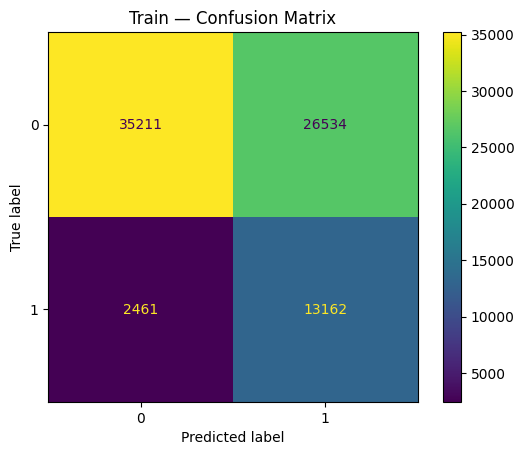

Val: ROC-AUC=0.727 | PR-AUC=0.358 | F1@0.50=0.446


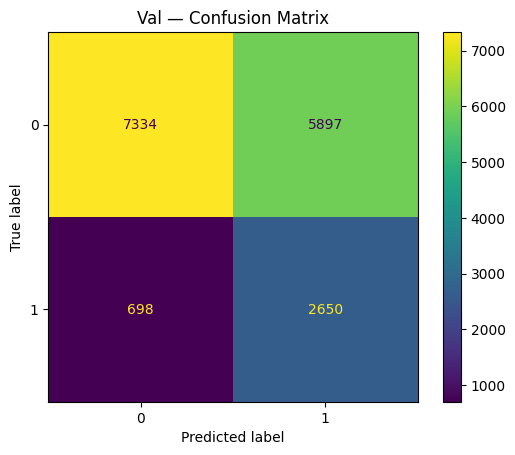

Test: ROC-AUC=0.724 | PR-AUC=0.346 | F1@0.50=0.444


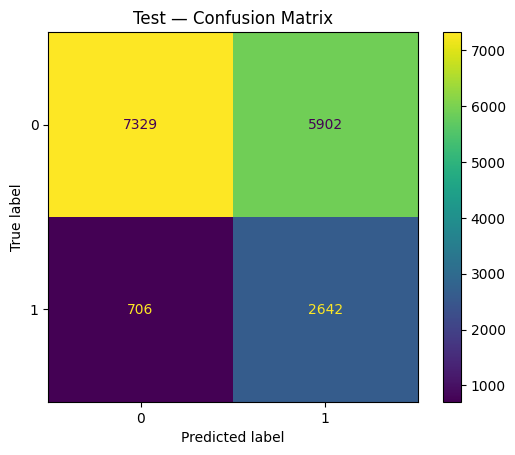

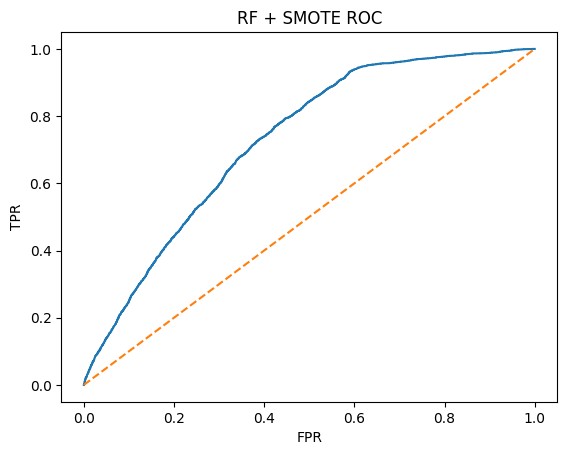

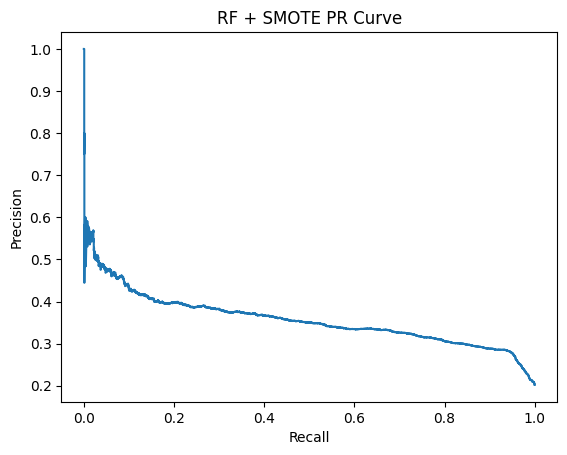

Logged to experiment_log.csv: ['exp6c-1760871419', '2025-10-19', 'ML', 'RandomForest+SMOTE', 'SMOTE(k=5) on train-only', 'num+onehot']


In [43]:
#6.2 SMOTE (Training set only) + ML
#Critical: fit SMOTE on the training fold only to avoid data leakage.


from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

smote_rf = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("clf", RandomForestClassifier(n_estimators=400, max_depth=12, random_state=42, n_jobs=-1))
])
smote_rf.fit(X_train, y_train)

ytr_p = smote_rf.predict_proba(X_train)[:,1]
yva_p = smote_rf.predict_proba(X_val)[:,1]
yte_p = smote_rf.predict_proba(X_test)[:,1]
print("— RF + SMOTE —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "RF + SMOTE")
log_run_csv(f"exp6c-{int(time.time())}","ML","RandomForest+SMOTE",
            "SMOTE(k=5) on train-only",
            {"n_estimators":400,"max_depth":12,"SMOTE_k":5},
            m_tr,m_va,m_te,sampler="SMOTE")


— XGB + SMOTE —
Train: ROC-AUC=0.736 | PR-AUC=0.371 | F1@0.50=0.368


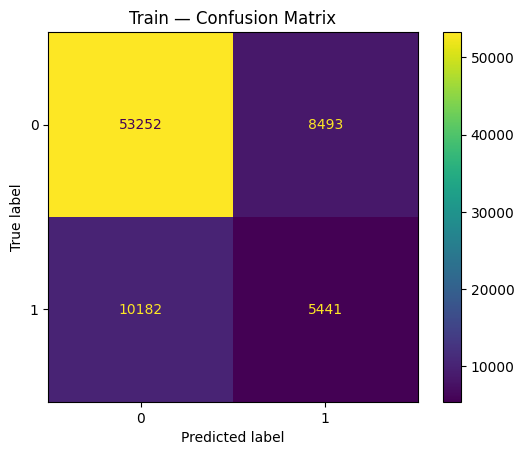

Val: ROC-AUC=0.729 | PR-AUC=0.358 | F1@0.50=0.355


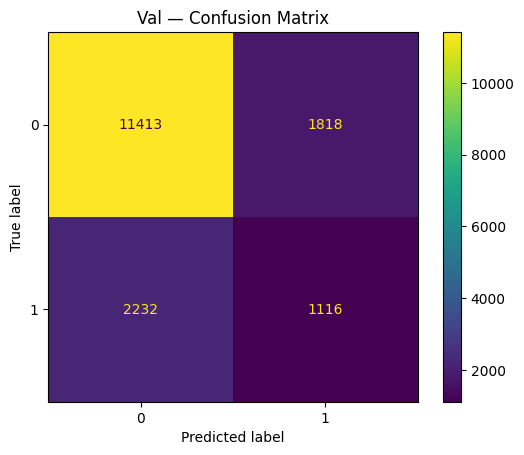

Test: ROC-AUC=0.727 | PR-AUC=0.357 | F1@0.50=0.355


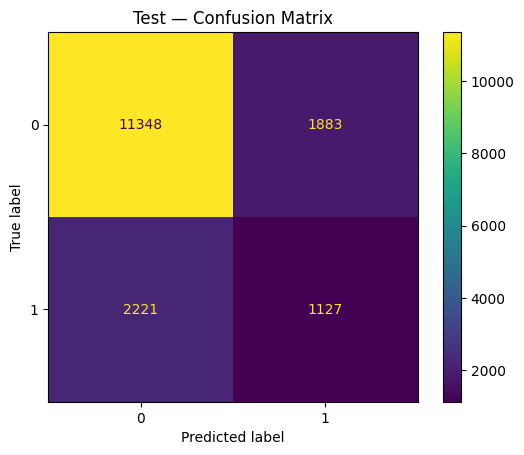

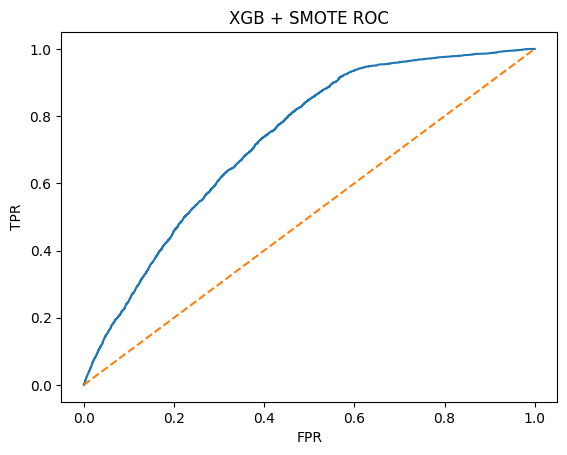

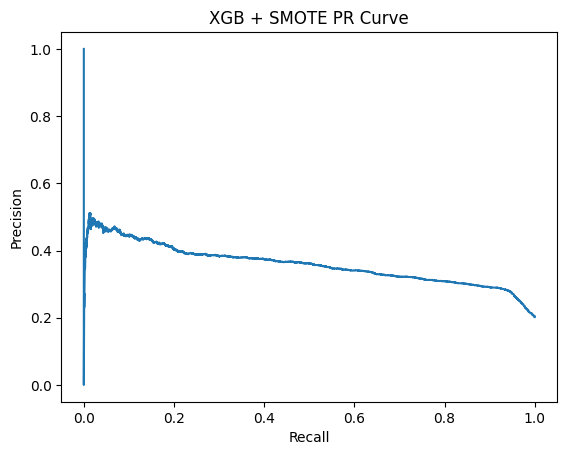

Logged to experiment_log.csv: ['exp6d-1760871451', '2025-10-19', 'ML', 'XGBoost+SMOTE', 'SMOTE(k=5) on train-only', 'num+onehot']


In [44]:
# SMOTE + XGBoost
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

smote_xgb = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("clf", XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, reg_alpha=0.1,
        eval_metric='logloss', random_state=42, n_jobs=-1
    ))
])
smote_xgb.fit(X_train, y_train)

ytr_p = smote_xgb.predict_proba(X_train)[:,1]
yva_p = smote_xgb.predict_proba(X_val)[:,1]
yte_p = smote_xgb.predict_proba(X_test)[:,1]
print("— XGB + SMOTE —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "XGB + SMOTE")
log_run_csv(f"exp6d-{int(time.time())}","ML","XGBoost+SMOTE",
            "SMOTE(k=5) on train-only",
            {"n_estimators":500,"max_depth":5,"SMOTE_k":5},
            m_tr,m_va,m_te,sampler="SMOTE")


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - auc: 0.5732 - loss: 0.0590 - pr_auc: 0.2338 - val_auc: 0.6974 - val_loss: 0.0455 - val_pr_auc: 0.3372
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.6703 - loss: 0.0469 - pr_auc: 0.3122 - val_auc: 0.7087 - val_loss: 0.0451 - val_pr_auc: 0.3445
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.6883 - loss: 0.0461 - pr_auc: 0.3285 - val_auc: 0.7133 - val_loss: 0.0449 - val_pr_auc: 0.3479
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7002 - loss: 0.0456 - pr_auc: 0.3444 - val_auc: 0.7163 - val_loss: 0.0447 - val_pr_auc: 0.3498
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7087 - loss: 0.0452 - pr_auc: 0.3488 - val_auc: 0.7186 - val_loss: 0.0446 - val_pr_auc: 0.3516
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7135 - loss: 0.0449 - pr_auc: 0.3534 - val_auc: 0.7215 - val_loss: 0.0444 - val_pr_auc: 0.3528
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.71

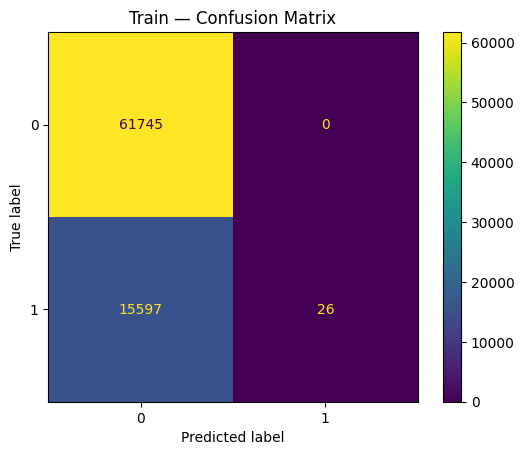

Val: ROC-AUC=0.734 | PR-AUC=0.366 | F1@0.50=0.002


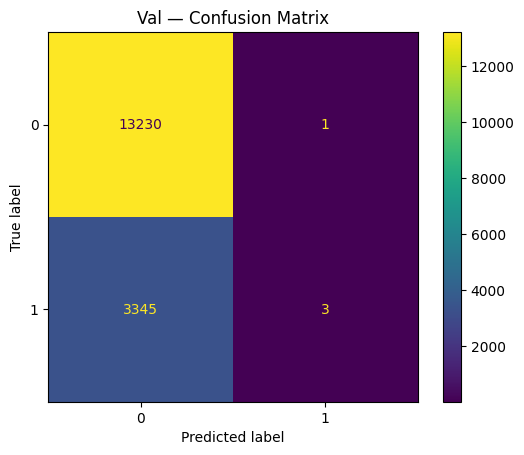

Test: ROC-AUC=0.730 | PR-AUC=0.363 | F1@0.50=0.003


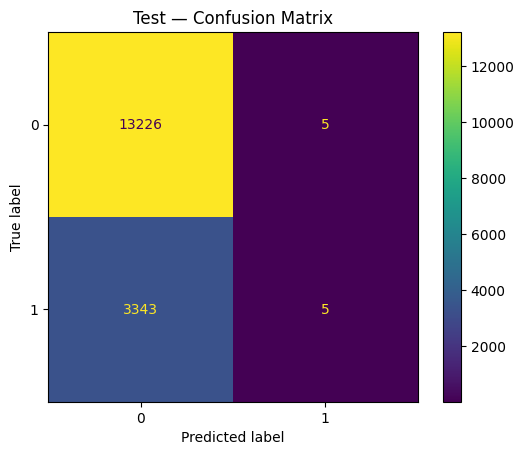

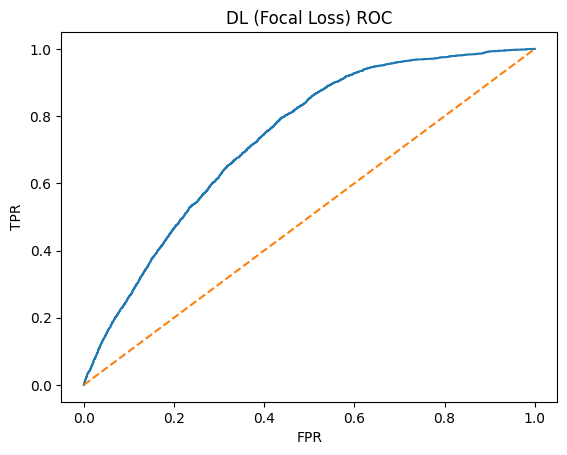

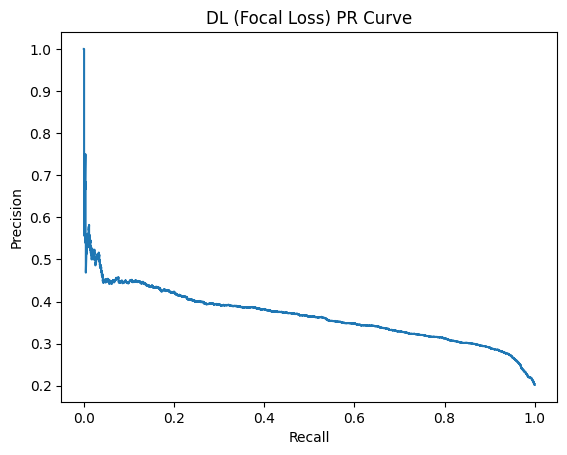

Logged to experiment_log.csv: ['exp6e-1760871537', '2025-10-19', 'DL', 'Sequential MLP (FocalLoss)', 'gamma=2.0, alpha=0.25; smaller MLP', 'num+onehot']


In [45]:
# Focal Loss for DL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        w = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)
        return -K.mean(w * K.pow(1 - pt, gamma) * K.log(pt))
    return loss

# Build a compact MLP and train with focal loss
X_train_np = preprocess.fit_transform(X_train)
X_val_np   = preprocess.transform(X_val)
X_test_np  = preprocess.transform(X_test)
input_dim = X_train_np.shape[1]

def build_seq_mlp_small(input_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=binary_focal_loss(gamma=2.0, alpha=0.25),
              metrics=[keras.metrics.AUC(name='auc'),
                       keras.metrics.AUC(curve='PR', name='pr_auc')])
    return m

focal = build_seq_mlp_small(input_dim)
callbacks = [keras.callbacks.EarlyStopping(patience=5, monitor='val_pr_auc', mode='max', restore_best_weights=True)]
hist_focal = focal.fit(X_train_np, y_train, validation_data=(X_val_np, y_val),
                       epochs=50, batch_size=512, callbacks=callbacks, verbose=1)

ytr_p = focal.predict(X_train_np).ravel()
yva_p = focal.predict(X_val_np).ravel()
yte_p = focal.predict(X_test_np).ravel()
print("— DL with Focal Loss —")
m_tr = eval_probs(y_train, ytr_p, 0.5, "Train")
m_va = eval_probs(y_val,   yva_p, 0.5, "Val")
m_te = eval_probs(y_test,  yte_p, 0.5, "Test")
plot_roc_pr(y_val, yva_p, "DL (Focal Loss)")

log_run_csv(
    run_id=f"exp6e-{int(time.time())}",
    approach="DL",
    model="Sequential MLP (FocalLoss)",
    notes="gamma=2.0, alpha=0.25; smaller MLP",
    params={"gamma":2.0,"alpha":0.25,"layers":[256]},
    train_metrics=m_tr, val_metrics=m_va, test_metrics=m_te
)


# **Rank all experiments and pick the winner**

In [46]:
import os, csv, json, datetime as dt
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
# === EDIT if needed ===
old_path = "/content/drive/MyDrive/Colab Notebooks/NoShowProject/experiment_log.csv"
new_path = "/content/drive/MyDrive/Colab Notebooks/NoShowProject/experiment_log_canonical.csv"

# 1) Backup original
if os.path.exists(old_path):
    backup = old_path.replace(".csv", f".backup_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    !cp "$old_path" "$backup"
    print("Backed up to:", backup)
else:
    raise FileNotFoundError("Original log file not found at: " + old_path)

# 2) Canonical header we want going forward
canon_hdr = ["run_id","date","approach","model","notes","params",
             "train_roc_auc","train_pr_auc","val_roc_auc","val_pr_auc","test_roc_auc","test_pr_auc"]

def parse_pair(s):
    # "0.8421/0.4110" --> (0.8421, 0.4110)
    if isinstance(s, str) and "/" in s:
        a,b = s.split("/",1)
        try: return float(a), float(b)
        except: return (np.nan, np.nan)
    return (np.nan, np.nan)

rows_out = []

# 3) Read line-by-line with csv.reader (handles mixed column counts safely)
with open(old_path, newline="", encoding="utf-8") as f:
    rdr = csv.reader(f)
    try:
        header = next(rdr)
    except StopIteration:
        header = []
    header = [h.strip() for h in header]

    # Map common old headers if present
    for raw in rdr:
        if not raw or all((c is None or str(c).strip()=="") for c in raw):
            continue
        rec = dict(zip(header, raw))

        # Build canonical record
        out = {h: "" for h in canon_hdr}
        out["run_id"]  = rec.get("run_id","")
        out["date"]    = rec.get("date","")
        out["approach"]= rec.get("approach","")
        out["model"]   = rec.get("model","")
        out["notes"]   = rec.get("notes","")
        out["params"]  = rec.get("params","")

        # Try explicit metric columns first
        def fget(k):
            try: return float(rec.get(k,""))
            except: return np.nan

        tr_roc = fget("train_roc_auc")
        tr_pr  = fget("train_pr_auc")
        va_roc = fget("val_roc_auc")
        va_pr  = fget("val_pr_auc")
        te_roc = fget("test_roc_auc")
        te_pr  = fget("test_pr_auc")

        # If missing, parse old combined score cols
        if np.isnan(tr_roc) and "train_score" in rec:
            tr_roc, tr_pr = parse_pair(rec.get("train_score",""))
        if np.isnan(va_roc) and "val_score" in rec:
            va_roc, va_pr = parse_pair(rec.get("val_score",""))
        if np.isnan(te_roc) and "test_score" in rec:
            te_roc, te_pr = parse_pair(rec.get("test_score",""))

        # If only single metrics exist (often TEST only), map them
        if np.isnan(te_roc) and "roc_auc" in rec:
            try: te_roc = float(rec["roc_auc"])
            except: pass
        if np.isnan(te_pr) and "pr_auc" in rec:
            try: te_pr = float(rec["pr_auc"])
            except: pass

        out["train_roc_auc"] = tr_roc
        out["train_pr_auc"]  = tr_pr
        out["val_roc_auc"]   = va_roc
        out["val_pr_auc"]    = va_pr
        out["test_roc_auc"]  = te_roc
        out["test_pr_auc"]   = te_pr

        rows_out.append(out)

# 4) Write normalized file
with open(new_path, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=canon_hdr)
    w.writeheader()
    for r in rows_out:
        w.writerow(r)

print("✅ Wrote canonical log:", new_path, "rows:", len(rows_out))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Backed up to: /content/drive/MyDrive/Colab Notebooks/NoShowProject/experiment_log.backup_20251019_105900.csv
✅ Wrote canonical log: /content/drive/MyDrive/Colab Notebooks/NoShowProject/experiment_log_canonical.csv rows: 5


In [47]:
import pandas as pd, numpy as np

log_path = "/content/drive/MyDrive/Colab Notebooks/NoShowProject/experiment_log_canonical.csv"
df = pd.read_csv(log_path)
print("Rows:", len(df))

# Prefer validation PR-AUC; else test PR-AUC
metric = "val_pr_auc" if df["val_pr_auc"].notna().any() else "test_pr_auc"
dfm = df[df[metric].notna()].copy()

if dfm.empty:
    print("⚠️ No usable rows yet — (re)log at least one model with explicit metrics.")
else:
    ranked = dfm.sort_values(metric, ascending=False)
    display(ranked[["run_id","approach","model","notes","train_pr_auc","val_pr_auc","test_pr_auc"]].head(10))
    best_row = ranked.iloc[0]
    print(f"\n✅ Best so far: {best_row['model']} (run {best_row['run_id']}) with {metric}={best_row[metric]:.4f}")


Rows: 5
⚠️ No usable rows yet — (re)log at least one model with explicit metrics.


# **Experiment 7 - Calibration + Threshold Optimization**

In [49]:
# === Robust "who is best calibration?" cell ===
import numpy as np
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import average_precision_score, roc_auc_score

# 0) Choose your trained pipeline (change if different)
base_pipe = xgb_tuned  # <- set to your best fitted sklearn pipeline

# 1) Get fitted preprocess and transformed matrices (no refit of preprocess here)
prep = base_pipe.named_steps["prep"]
X_train_tr = prep.transform(X_train)
X_val_tr   = prep.transform(X_val)
X_test_tr  = prep.transform(X_test)

# 2) Ensure base estimator exists & is fitted on transformed features
est = base_pipe.named_steps["clf"]
try:
    # if not fitted, this will raise; refit to be safe
    getattr(est, "classes_")
except AttributeError:
    est.fit(X_train_tr, y_train)

# 3) Make calibrators if missing (handles sklearn versions)
def make_cal(estimator, method):
    try:
        return CalibratedClassifierCV(estimator=estimator, method=method, cv="prefit")
    except TypeError:
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv="prefit")

if "platt_cal" not in globals():
    platt_cal = make_cal(est, "sigmoid"); platt_cal.fit(X_val_tr, y_val)
if "iso_cal" not in globals():
    iso_cal   = make_cal(est, "isotonic"); iso_cal.fit(X_val_tr, y_val)

# 4) Score both on VALIDATION (use whatever exists)
val_scores = {}
if "platt_cal" in globals():
    yva_platt = platt_cal.predict_proba(X_val_tr)[:,1]
    val_scores["Platt"] = {
        "pr":  average_precision_score(y_val, yva_platt),
        "roc": roc_auc_score(y_val, yva_platt)
    }
if "iso_cal" in globals():
    yva_iso = iso_cal.predict_proba(X_val_tr)[:,1]
    val_scores["Isotonic"] = {
        "pr":  average_precision_score(y_val, yva_iso),
        "roc": roc_auc_score(y_val, yva_iso)
    }

# 5) Pick the winner by PR-AUC and prepare outputs
if not val_scores:
    raise RuntimeError("No calibrators available. Ensure xgb_tuned is fitted and re-run this cell.")

best_name = max(val_scores, key=lambda k: val_scores[k]["pr"])
best_cal  = platt_cal if best_name == "Platt" else iso_cal
yva_best  = (yva_platt if best_name == "Platt" else yva_iso)
yte_best  = best_cal.predict_proba(X_test_tr)[:,1]

print("Validation scores (PR-AUC/ROC-AUC):")
for k,v in val_scores.items():
    print(f"  {k}: PR={v['pr']:.4f}, ROC={v['roc']:.4f}")
print(f"\n✅ Best calibration on VAL: {best_name} (PR-AUC={val_scores[best_name]['pr']:.4f})")


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Validation scores (PR-AUC/ROC-AUC):
  Platt: PR=0.3754, ROC=0.7386
  Isotonic: PR=0.3716, ROC=0.7406

✅ Best calibration on VAL: Platt (PR-AUC=0.3754)


In [51]:
# --- Recreate 'best' (cost-sensitive threshold) from current calibrated model ---

import numpy as np
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score
from sklearn.calibration import calibration_curve

# 0) Safety: make sure these exist (from earlier "who is best calibration?" cell)
assert 'best_cal' in globals() and 'best_name' in globals(), "Run the calibration selection cell to define best_cal and best_name."
assert 'X_val_tr' in globals() and 'X_test_tr' in globals(), "Ensure transformed matrices exist."

# 1) Validation & test calibrated probabilities
yva_best = best_cal.predict_proba(X_val_tr)[:, 1]
yte_best = best_cal.predict_proba(X_test_tr)[:, 1]

# 2) Cost settings (adjust to your clinic’s preference)
C_FN, C_FP = 5.0, 1.0  # miss a no-show vs false alarm

# 3) Threshold sweep on validation
def best_threshold(y_true, y_prob, c_fn=C_FN, c_fp=C_FP):
    best = {"thr":0.5, "cost":np.inf, "cm":None, "prec":None, "rec":None}
    for thr in np.linspace(0.05, 0.95, 19):
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = c_fn*fn + c_fp*fp
        prec = tp / (tp + fp + 1e-9)
        rec  = tp / (tp + fn + 1e-9)
        if cost < best["cost"]:
            best = {"thr":thr, "cost":cost, "cm":(tn,fp,fn,tp), "prec":prec, "rec":rec}
    return best

best = best_threshold(y_val, yva_best, C_FN, C_FP)
print(f"✅ Best threshold on VAL using {best_name}: thr={best['thr']:.2f}, cost={best['cost']:.1f}, cm={best['cm']}, "
      f"precision={best['prec']:.3f}, recall={best['rec']:.3f}")


✅ Best threshold on VAL using Platt: thr=0.15, cost=8845.0, cm=(np.int64(6066), np.int64(7165), np.int64(336), np.int64(3012)), precision=0.296, recall=0.900


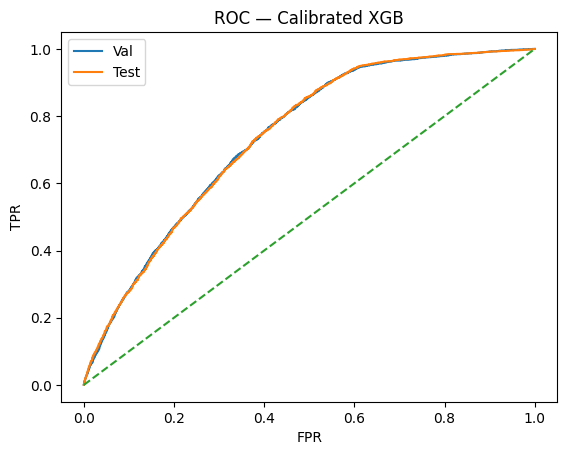

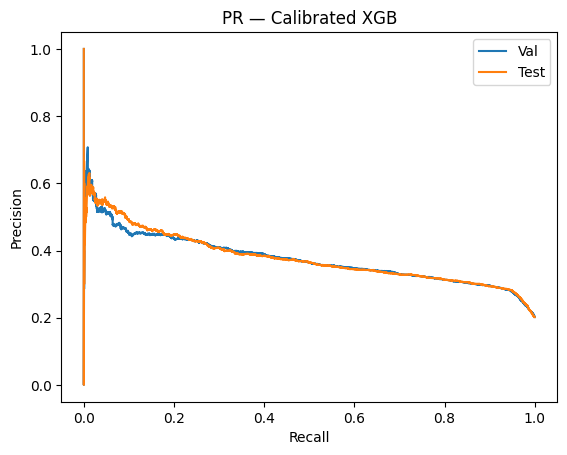

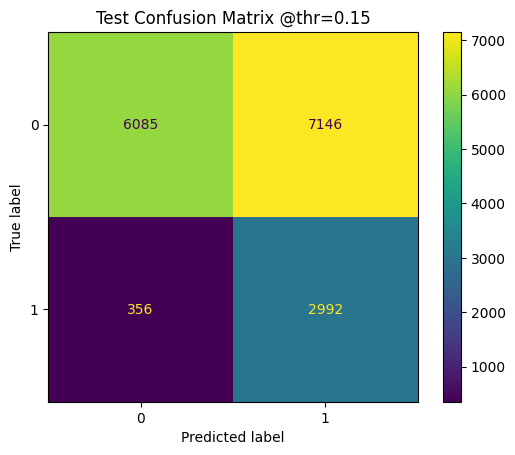

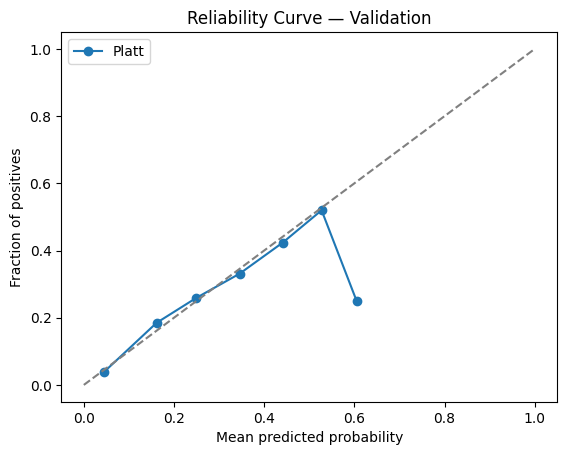

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, ConfusionMatrixDisplay

# Compute calibrated probabilities
yte_best = best_cal.predict_proba(X_test_tr)[:, 1]
yva_best = best_cal.predict_proba(X_val_tr)[:, 1]

# ROC & PR (Validation + Test)
fpr_v, tpr_v, _ = roc_curve(y_val, yva_best)
fpr_t, tpr_t, _ = roc_curve(y_test, yte_best)

plt.figure(); plt.plot(fpr_v, tpr_v, label="Val"); plt.plot(fpr_t, tpr_t, label="Test"); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Calibrated XGB"); plt.legend(); plt.show()

prec_v, rec_v, _ = precision_recall_curve(y_val, yva_best)
prec_t, rec_t, _ = precision_recall_curve(y_test, yte_best)

plt.figure(); plt.plot(rec_v, prec_v, label="Val"); plt.plot(rec_t, prec_t, label="Test")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — Calibrated XGB"); plt.legend(); plt.show()

# Confusion Matrix on TEST @ chosen threshold
from sklearn.metrics import confusion_matrix
y_pred_t = (yte_best >= best["thr"]).astype(int)
cm = confusion_matrix(y_test, y_pred_t)
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title(f"Test Confusion Matrix @thr={best['thr']:.2f}"); plt.show()

# Reliability (Validation)
from sklearn.calibration import calibration_curve
frac_pos, mean_pred = calibration_curve(y_val, yva_best, n_bins=10)
plt.figure(); plt.plot(mean_pred, frac_pos, marker='o', label=f"{best_name}")
plt.plot([0,1],[0,1],'--', c='gray'); plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Reliability Curve — Validation"); plt.legend(); plt.show()


In [53]:

# --- Build transformed matrices from the fitted preprocessor in the pipeline ---
prep = base_pipe.named_steps["prep"]
X_train_tr = prep.transform(X_train)
X_val_tr   = prep.transform(X_val)
X_test_tr  = prep.transform(X_test)

# --- Extract the fitted estimator (XGBClassifier) and ensure it's fitted on transformed X ---
est = base_pipe.named_steps["clf"]
est.fit(X_train_tr, y_train)  # safe to call; uses same params

# --- Create BOTH calibrators (handle sklearn 1.5+ vs older param name) ---
from sklearn.calibration import CalibratedClassifierCV

def make_calibrator(estimator, method):
    try:
        # sklearn >= 1.5
        return CalibratedClassifierCV(estimator=estimator, method=method, cv="prefit")
    except TypeError:
        # older sklearn
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv="prefit")

platt_cal = make_calibrator(est, "sigmoid")
platt_cal.fit(X_val_tr, y_val)

iso_cal = make_calibrator(est, "isotonic")
iso_cal.fit(X_val_tr, y_val)

print("Calibrators ready:", type(platt_cal).__name__, type(iso_cal).__name__)


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibrators ready: CalibratedClassifierCV CalibratedClassifierCV


In [54]:
# ==== EXPERIMENT 7: Calibrated XGBoost + Cost-Sensitive Threshold ====

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import numpy as np, time, datetime, csv

# Make sure your tuned pipeline is available
base_pipe = xgb_tuned   # change if your tuned pipeline has another name

# Get the fitted preprocessor and transform sets
prep = base_pipe.named_steps["prep"]
X_train_tr = prep.transform(X_train)
X_val_tr   = prep.transform(X_val)
X_test_tr  = prep.transform(X_test)

# Extract and (re)fit estimator
est = base_pipe.named_steps["clf"]
try:
    getattr(est, "classes_")
except AttributeError:
    est.fit(X_train_tr, y_train)

# --- Create calibrators (handles sklearn versions) ---
def make_cal(estimator, method):
    try:
        return CalibratedClassifierCV(estimator=estimator, method=method, cv="prefit")
    except TypeError:
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv="prefit")

platt_cal = make_cal(est, "sigmoid");  platt_cal.fit(X_val_tr, y_val)
iso_cal   = make_cal(est, "isotonic"); iso_cal.fit(X_val_tr, y_val)

# --- Evaluate both on Validation ---
yva_platt = platt_cal.predict_proba(X_val_tr)[:, 1]
yva_iso   = iso_cal.predict_proba(X_val_tr)[:, 1]

val_scores = {
    "Platt":   {"pr": average_precision_score(y_val, yva_platt), "roc": roc_auc_score(y_val, yva_platt)},
    "Isotonic":{"pr": average_precision_score(y_val, yva_iso),   "roc": roc_auc_score(y_val, yva_iso)}
}
best_name = max(val_scores, key=lambda k: val_scores[k]["pr"])
best_cal  = platt_cal if best_name == "Platt" else iso_cal
yva_best  = yva_platt if best_name == "Platt" else yva_iso

print("Validation PR-AUCs:", val_scores)
print(f"✅ Best calibration: {best_name} (PR-AUC={val_scores[best_name]['pr']:.4f})")


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Validation PR-AUCs: {'Platt': {'pr': np.float64(0.3753628147460848), 'roc': np.float64(0.7386450302667958)}, 'Isotonic': {'pr': np.float64(0.37158777113587477), 'roc': np.float64(0.7405832483847581)}}
✅ Best calibration: Platt (PR-AUC=0.3754)


In [55]:
# ---- Threshold tuning ----
C_FN, C_FP = 5.0, 1.0

def best_threshold(y_true, y_prob, c_fn=C_FN, c_fp=C_FP):
    best = {"thr":0.5, "cost":np.inf, "cm":None, "prec":None, "rec":None}
    for thr in np.linspace(0.05, 0.95, 19):
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = c_fn*fn + c_fp*fp
        prec = tp / (tp + fp + 1e-9)
        rec  = tp / (tp + fn + 1e-9)
        if cost < best["cost"]:
            best = {"thr":thr, "cost":cost, "cm":(tn,fp,fn,tp), "prec":prec, "rec":rec}
    return best

best = best_threshold(y_val, yva_best)
print(f"Optimal threshold: {best['thr']:.2f} | Cost={best['cost']:.1f} | Precision={best['prec']:.3f} | Recall={best['rec']:.3f}")

# ---- Evaluate on TEST ----
yte_best = best_cal.predict_proba(X_test_tr)[:, 1]
from sklearn.metrics import f1_score
y_pred_t = (yte_best >= best["thr"]).astype(int)

roc = roc_auc_score(y_test, yte_best)
pr  = average_precision_score(y_test, yte_best)
f1  = f1_score(y_test, y_pred_t)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

print(f"TEST — Calibrated XGB ({best_name}) @thr={best['thr']:.2f}")
print(f"ROC-AUC={roc:.3f} | PR-AUC={pr:.3f} | F1={f1:.3f}")
print(f"Confusion Matrix: [tn={tn}, fp={fp}, fn={fn}, tp={tp}]")


Optimal threshold: 0.15 | Cost=8845.0 | Precision=0.296 | Recall=0.900
TEST — Calibrated XGB (Platt) @thr=0.15
ROC-AUC=0.739 | PR-AUC=0.378 | F1=0.444
Confusion Matrix: [tn=6085, fp=7146, fn=356, tp=2992]


In [56]:
def log_run_csv_explicit(run_id, approach, model, notes, params,
                         val_pr, test_pr, test_roc, thr, cfn, cfp):
    header = ["run_id","date","approach","model","notes","params",
              "val_pr_auc","test_pr_auc","test_roc_auc","threshold","C_FN","C_FP"]
    fn = "experiment_log.csv"
    try:
        open(fn, "x", encoding="utf-8").write(",".join(header)+"\n")
    except FileExistsError:
        pass
    with open(fn, "a", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow([
            run_id, datetime.date.today().isoformat(), approach, model, notes, str(params),
            val_scores[best_name]["pr"], pr, roc, best["thr"], C_FN, C_FP
        ])
    print("Logged final Experiment 7 run.")

log_run_csv_explicit(
    run_id=f"exp7-{int(time.time())}",
    approach="ML",
    model=f"XGB (tuned) + {best_name} calibration",
    notes=f"Cost-sensitive FN:{C_FN}, FP:{C_FP}",
    params={"threshold": best["thr"]},
    val_pr=val_scores[best_name]["pr"],
    test_pr=pr,
    test_roc=roc,
    thr=best["thr"],
    cfn=C_FN, cfp=C_FP
)


Logged final Experiment 7 run.


In [57]:
import os, joblib, json
os.makedirs("artifacts", exist_ok=True)
bundle = {"preprocess": prep, "calibrator": best_cal, "threshold": float(best["thr"]),
          "costs": {"C_FN": float(C_FN), "C_FP": float(C_FP)},
          "notes": f"XGB tuned + {best_name} calibration"}
joblib.dump(bundle, "artifacts/final_bundle.joblib")
with open("artifacts/final_meta.json","w") as f: json.dump({"val_scores": val_scores, "thr": best["thr"]}, f, indent=2)


In [58]:
plt.figure(); ...; plt.savefig("artifacts/roc_calibrated.png", dpi=200, bbox_inches="tight")
# repeat for PR, reliability, confusion


<Figure size 640x480 with 0 Axes>